# A Reliability Concern on Photonic Neural Networks
- **Author:** LIU Yinyi
- **Test-Date:** Aug. 22, 2021
- **Version:** 0.1.1 
- **Conference:** DATE 2022

**Overview**    
This Notebook contains the implements of:

- [x] LeNet-5 Architecture and Weight Extractions
- [x] Loss and Crosstalk-aware Unitary Blocks
- [x] Decomposition Methods (Reck, Clements)
- [x] Trends of Worst-case Mode-wise SNR
- [x] Evaluation Platform for Photonic Neural Networks

In [1]:
import os
import sys
from datetime import datetime

import numpy as np
import sympy as sp
from typing import Union
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from numba import jit

%matplotlib inline

# Torch LeNet-5
- @Credit to [Eryk Lewinson](https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320) whose blog is published on the Towards-Data-Science website.

## Parameter Setup

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

RANDOM_SEED = 20210701
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 5

IMG_SIZE = 32
N_CLASSES = 10

## Model Architecture

In [3]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

## Helper Functions

In [4]:
# define transform
transform = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
download_flag = False if os.path.exists('data/MNIST') else False

train_dataset = datasets.MNIST(root='data/MNIST', 
                               train=True, 
                               transform=transform,
                               download=True)

valid_dataset = datasets.MNIST(root='data/MNIST', 
                               train=False, 
                               transform=transform)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)


Extracting data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/MNIST/raw




Extracting data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw




Extracting data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/MNIST/raw




Extracting data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/MNIST/raw

Processing...
Done!


In [5]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

In [6]:
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [7]:
def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

In [8]:
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

## Training

In [9]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

19:21:13 --- Epoch: 0	Train loss: 0.2486	Valid loss: 0.1017	Train accuracy: 97.04	Valid accuracy: 96.79
19:21:47 --- Epoch: 1	Train loss: 0.0840	Valid loss: 0.0756	Train accuracy: 98.01	Valid accuracy: 97.56
19:22:20 --- Epoch: 2	Train loss: 0.0581	Valid loss: 0.0671	Train accuracy: 98.45	Valid accuracy: 97.90
19:22:54 --- Epoch: 3	Train loss: 0.0450	Valid loss: 0.0524	Train accuracy: 98.89	Valid accuracy: 98.25
19:23:31 --- Epoch: 4	Train loss: 0.0377	Valid loss: 0.0456	Train accuracy: 99.20	Valid accuracy: 98.53


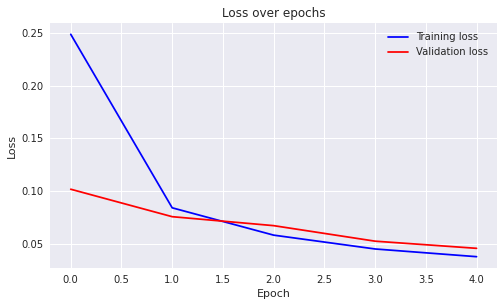

In [10]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

# Unitary Decomposition

## Helper Functions

In [11]:
@jit(nopython=True)
def atan2f(y, x, tolerance=1e-6, to_degree=False):
    zero_y = np.abs(y) <= tolerance
    zero_x = np.abs(x) <= tolerance
    if zero_x and zero_y:
        rad = 0
    elif zero_x and (not zero_y):
        rad = np.pi/2 if y > tolerance else -np.pi/2
    elif (not zero_x) and zero_y:
        rad = 0 if x > tolerance else np.pi
    else:
        rad = np.arctan2(y, x)
    if to_degree:
        return np.rad2deg(rad)
    else:
        return rad
    

@jit(nopython=True)
def angle_diff(comp_src, comp_dst, offset=0, tolerance=1e-6, wrap=True, to_degree=False):
    zero_src = np.abs(comp_src) <= tolerance
    zero_dst = np.abs(comp_dst) <= tolerance
    if zero_src and zero_dst:
        rad = 0
    elif zero_src and (not zero_dst):
        rad = np.angle(comp_dst)
    elif (not zero_src) and zero_dst:
        rad = -np.angle(comp_src)
    else:
        rad = np.angle(comp_dst) - np.angle(comp_src)
    rad += offset
    if wrap:
        rad = np.mod(rad, 2 * np.pi)
    if to_degree:
        return np.rad2deg(rad)
    else:
        return rad

## Types of Unitary Blocks

In [12]:
def U2BS(dim, m, n, phi, theta, use_sym=False, Lp=1, Lc=1):
    assert m < n < dim
    if use_sym:
        mat = sp.eye(dim)
        mat[m, m] = sp.sqrt(Lp) * sp.exp(sp.I * phi) * sp.cos(theta)
        mat[m, n] = sp.sqrt(Lc) * sp.I * sp.sin(theta)
        mat[n, m] = sp.sqrt(Lc) * sp.I * sp.exp(sp.I * phi) * sp.sin(theta)
        mat[n, n] = sp.sqrt(Lp) * sp.cos(theta)
    else:
        mat = np.eye(dim, dtype=np.complex128)
        mat[m, m] = np.sqrt(Lp) * np.exp(1j * phi) * np.cos(theta)
        mat[m, n] = np.sqrt(Lc) * 1j * np.sin(theta)
        mat[n, m] = np.sqrt(Lc) * 1j * np.exp(1j * phi) * np.sin(theta)
        mat[n, n] = np.sqrt(Lp) * np.cos(theta)
    return mat


def U2MZI(dim, m, n, phi, theta, use_sym=False, Lp=1, Lc=1):
    assert m < n < dim
    if use_sym:
        mat = sp.eye(dim)
        mat[m, m] = sp.sqrt(Lp) * sp.I * sp.exp(sp.I * phi) * sp.sin(theta)
        mat[m, n] = sp.sqrt(Lc) * sp.I * sp.cos(theta)
        mat[n, m] = sp.sqrt(Lc) * sp.I * sp.exp(sp.I * phi) * sp.cos(theta)
        mat[n, n] = -sp.sqrt(Lp) * sp.I * sp.sin(theta)
    else:
        mat = np.eye(dim, dtype=np.complex128)
        mat[m, m] = np.sqrt(Lp) * 1j *np.exp(1j * phi) * np.sin(theta)
        mat[m, n] = np.sqrt(Lc) * 1j * np.cos(theta)
        mat[n, m] = np.sqrt(Lc) * 1j * np.exp(1j * phi) * np.cos(theta)
        mat[n, n] = -np.sqrt(Lp) * 1j * np.sin(theta)
    return mat

## Decomposition Methods

### Reck's Encoding

In [13]:
def decompose_reck(u, block='bs'):
    assert isinstance(u, np.ndarray)
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    if len(u.shape) != 2:
        raise ValueError("U(N) should be 2-dimension matrix.")
        
    if u.shape[0] != u.shape[1]:
        raise ValueError("U(N) should be a square matrix.")
        
    mat = u.copy().astype(np.complex128)
    dim = mat.shape[0]
    num = int(dim * (dim - 1) / 2)
    phis = np.zeros(num)
    thetas = np.zeros(num)
    alphas = np.zeros(dim)
    index = 0
    for p in range(1, dim):
        x = dim - p
        for q in range(dim-p, 0, -1):
            y = q - 1
            if block == 'bs':
                thetas[index] = atan2f(np.abs(mat[x,y]), np.abs(mat[x,x]))
                phis[index] = angle_diff(mat[x,x], mat[x,y], offset=-np.pi/2)
                U2block = U2BS
            elif block == 'mzi':
                thetas[index] = np.pi/2 - atan2f(np.abs(mat[x,y]), np.abs(mat[x,x]))
                phis[index] = angle_diff(mat[x,x], mat[x,y], offset=np.pi)
                U2block = U2MZI
            mat = mat @ U2block(dim, y, x, phis[index], thetas[index]).conj().T
            index += 1
    for i in range(dim):
        alphas[i] = np.angle(mat[i, i])
    return phis, thetas, alphas


def reconstruct_reck(phis, thetas, alphas, block='bs', Lp_dB=0, Lc_dB=0):
    assert len(phis.squeeze().shape) == 1
    assert len(thetas.squeeze().shape) == 1
    assert len(alphas.squeeze().shape) == 1
    assert phis.squeeze().shape[0] == thetas.squeeze().shape[0]
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    if block == 'bs':
        U2block = U2BS
    elif block == 'mzi':
        U2block = U2MZI
    
    num = thetas.squeeze().shape[0]
    dim = int((1 + np.sqrt(1 + 8 * num))/ 2)
    assert alphas.squeeze().shape[0] == dim
    
    Lp = 10 ** (Lp_dB / 10)
    Lc = 10 ** (Lc_dB / 10)
    
    mat = np.diag(np.exp(1j * alphas))
    index = num
    for p in range(1, dim):
        for q in range(p):
            index -= 1
            mat = mat @ U2block(dim, q, p, phis[index], thetas[index], Lp=Lp, Lc=Lc)
    return mat

### Clements' Encoding

In [14]:
def decompose_clements(u, block='bs'):
    assert isinstance(u, np.ndarray)
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    if len(u.shape) != 2:
        raise ValueError("U(N) should be 2-dimension matrix.")
        
    if u.shape[0] != u.shape[1]:
        raise ValueError("U(N) should be a square matrix.")
        
    mat = u.copy().astype(np.complex128)
    dim = mat.shape[0]
    
    row = dim - 1
    col = int(np.ceil(dim / 2))
    
    cnt_fore = np.zeros(row, dtype=int)
    cnt_back = np.ones(row, dtype=int) * (col - 1)
    if dim % 2 == 1:
        cnt_back[1::2] = col - 2
    
    phis = np.zeros((row, col))
    thetas = np.zeros((row, col))
    alphas = np.zeros(dim)
    
    for p in range(dim-1):
        for q in range(p+1):
            if p % 2 == 0:
                x = dim - 1 - q
                y = p - q
                if block == 'bs':
                    theta = atan2f(np.abs(mat[x,y]), np.abs(mat[x,y+1]))
                    phi = angle_diff(mat[x,y+1], mat[x,y], offset=-np.pi/2)
                    U2block = U2BS
                elif block == 'mzi':
                    theta = np.pi/2 - atan2f(np.abs(mat[x,y]), np.abs(mat[x,y+1]))
                    phi = angle_diff(mat[x,y+1], mat[x,y], offset=np.pi)
                    U2block = U2MZI
                mat = mat @ U2block(dim, y, y+1, phi, theta).conj().T
                thetas[y, cnt_fore[y]] = theta
                phis[y, cnt_fore[y]] = phi
                cnt_fore[y] += 1
            else:
                x = dim - 1 - p + q
                y = q
                if block == 'bs':
                    theta = atan2f(np.abs(mat[x,y]), np.abs(mat[x-1,y]))
                    phi = angle_diff(mat[x-1,y], mat[x,y], offset=np.pi/2)
                    U2block = U2BS
                elif block == 'mzi':
                    theta = np.pi/2 - atan2f(np.abs(mat[x,y]), np.abs(mat[x-1,y]))
                    phi = angle_diff(mat[x-1,y], mat[x,y], offset=0)
                    U2block = U2MZI
                mat = U2block(dim, x-1, x, phi, theta) @ mat
                thetas[x-1, cnt_back[x-1]] = theta
                phis[x-1, cnt_back[x-1]] = phi
                cnt_back[x-1] -= 1
    for p in range(dim-2, -1, -1):
        for q in range(p, -1, -1):
            if p % 2 == 0:
                continue
            x = dim - 1 - p + q
            y = q
            cnt_back[x-1] += 1
            theta = thetas[x-1, cnt_back[x-1]]
            phi = phis[x-1, cnt_back[x-1]]
            eta1 = mat[x-1, x-1]
            eta2 = mat[x, x]
            if block == 'bs':
                phi_new = angle_diff(eta2, -eta1, offset=0)
                mat[x-1, x-1] = eta1 * np.exp(-1j * (phi+phi_new))
            elif block == 'mzi':
                phi_new = angle_diff(eta2, eta1, offset=0)
                mat[x-1, x-1] = -eta1 * np.exp(-1j * (phi+phi_new))
                mat[x, x] = -eta2
            phis[x-1, cnt_back[x-1]] = phi_new
    for i in range(dim):
        alphas[i] = np.angle(mat[i, i])
    return phis, thetas, alphas


def reconstruct_clements(phis, thetas, alphas, block='bs', Lp_dB=0, Lc_dB=0):
    assert len(phis.squeeze().shape) == 2
    assert len(thetas.squeeze().shape) == 2
    assert len(alphas.squeeze().shape) == 1
    assert phis.squeeze().shape == thetas.squeeze().shape
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    
    if block == 'bs':
        U2block = U2BS
    elif block == 'mzi':
        U2block = U2MZI
    
    row, col = thetas.squeeze().shape
    dim = row + 1
    num = int(dim * (dim - 1) / 2) 
    assert alphas.squeeze().shape[0] == dim
    
    Lp = 10 ** (Lp_dB / 10)
    Lc = 10 ** (Lc_dB / 10)
    
    sft = np.diag(np.exp(1j * alphas))
    mat = np.eye(dim)
    for p in range(col):
        for q in range(0, row, 2):
            mat = U2block(dim, q, q+1, phis[q,p], thetas[q,p], Lp=Lp, Lc=Lc) @ mat
        if p >= col - 1 and dim % 2 == 1:
            continue
        for q in range(1, row, 2):
            mat = U2block(dim, q, q+1, phis[q,p], thetas[q,p], Lp=Lp, Lc=Lc) @ mat
    mat = sft @ mat
    return mat

### Unit Test

In [15]:
# Parameter To Test
BOUND = 100
MAT_ROW = 40
MAT_COL = 50
print('==== Unit Test ====')

# Singular Value Decomposition
mat = np.random.randint(-np.abs(BOUND), np.abs(BOUND), (MAT_ROW, MAT_COL))
[u, s, v] = np.linalg.svd(mat, full_matrices=True)

# Recovery from SVD
print(f'Recovery from SVD:\t {np.allclose(mat, u[:, :MAT_COL] @ np.diag(s) @ v[:MAT_ROW, :])}')

# Reck BS
[p, t, a] = decompose_reck(u, block='bs')
reck_test = reconstruct_reck(p, t, a, block='bs')
print(f'Reck[BS] Test:\t\t {np.allclose(reck_test, u)}')

# Reck MZI
[p, t, a] = decompose_reck(u, block='mzi')
reck_test = reconstruct_reck(p, t, a, block='mzi')
print(f'Reck[MZI] Test:\t\t {np.allclose(reck_test, u)}')

# Clements BS
[p, t, a] = decompose_clements(u, block='bs')
clements_test = reconstruct_clements(p, t, a, block='bs')
print(f'Clements[BS] Test:\t {np.allclose(clements_test, u)}')

# Clements MZI
[p, t, a] = decompose_clements(u, block='mzi')
clements_test = reconstruct_clements(p, t, a, block='mzi')
print(f'Clements[MZI] Test:\t {np.allclose(clements_test, u)}')

==== Unit Test ====
Recovery from SVD:	 True
Reck[BS] Test:		 True
Reck[MZI] Test:		 True
Clements[BS] Test:	 True
Clements[MZI] Test:	 True


# Photonic Neural Networks

## Lossy and Crosstalk-aware Unitary Blocks

### Symbolic-enabled Unitary Blocks in consideration of Loss and Crosstalk

In [16]:
def UB2BS(dim, m, n, phi, theta, E_in, P_x, use_sym=False, Lp=1, Lc=1, K1=0, K2=0):
    assert m < n < dim
    
    if use_sym:
        E_signal = sp.eye(2)
        E_signal[0, 0] = sp.sqrt(Lp) * sp.exp(sp.I * phi) * sp.cos(theta)
        E_signal[0, 1] = sp.sqrt(Lc) * sp.I * sp.sin(theta)
        E_signal[1, 0] = sp.sqrt(Lc) * sp.I * sp.exp(sp.I * phi) * sp.sin(theta)
        E_signal[1, 1] = sp.sqrt(Lp) * sp.cos(theta)
        E_port = E_signal @ E_in.extract([m, n], [0])
        E_out = E_in.copy()
        E_out[m] = E_port[0]
        E_out[n] = E_port[1]
        
        P_crosstalk = sp.eye(2)
        P_crosstalk[0, 0] = K1 * (sp.sin(theta) ** 2)
        P_crosstalk[0, 1] = K2 * (sp.cos(theta) ** 2)
        P_crosstalk[1, 0] = K2 * (sp.cos(theta) ** 2)
        P_crosstalk[1, 1] = K1 * (sp.sin(theta) ** 2)
        P_port = P_crosstalk @ (sp.Abs(E_in.extract([m, n], [0])).applyfunc(lambda x: x ** 2) + P_x.extract([m, n], [0]))
        P_port += (sp.Abs(E_signal).applyfunc(lambda x: x ** 2)) @ P_x.extract([m, n], [0])
        P_out = P_x.copy()
        P_out[m] = P_port[0]
        P_out[n] = P_port[1]
        
    else:
        assert 0 <= Lp <= 1 and 0 <= Lc <= 1
        assert 0 <= K1 <= 1 and 0 <= K2 <= 1
        assert np.ndim(E_in.squeeze()) == 1 and np.ndim(P_x.squeeze()) == 1
        assert E_in.squeeze().shape[0] == dim and P_x.squeeze().shape[0] == dim
        
        E_signal = np.eye(2, dtype=np.complex128)
        E_signal[0, 0] = np.sqrt(Lp) * np.exp(1j * phi) * np.cos(theta)
        E_signal[0, 1] = np.sqrt(Lc) * 1j * np.sin(theta)
        E_signal[1, 0] = np.sqrt(Lc) * 1j * np.exp(1j * phi) * np.sin(theta)
        E_signal[1, 1] = np.sqrt(Lp) * np.cos(theta)
        E_port = E_signal @ E_in.squeeze()[np.ix_([m, n])]
        E_out = E_in.squeeze().copy()
        E_out[m] = E_port[0]
        E_out[n] = E_port[1]
        E_out = E_out.reshape(E_in.shape)
        
        P_crosstalk = np.eye(2)
        P_crosstalk[0, 0] = K1 * (np.sin(theta) ** 2)
        P_crosstalk[0, 1] = K2 * (np.cos(theta) ** 2)
        P_crosstalk[1, 0] = K2 * (np.cos(theta) ** 2)
        P_crosstalk[1, 1] = K1 * (np.sin(theta) ** 2)
        P_port = P_crosstalk @ (np.square(np.abs(E_in.squeeze()[np.ix_([m,n])])) + P_x.squeeze()[np.ix_([m,n])])
        P_out = P_x.squeeze().copy()
        P_out[m] = P_port[0]
        P_out[n] = P_port[1]
        P_out = P_out.reshape(P_x.shape)
        
    return E_out, P_out


def UB2MZI(dim, m, n, phi, theta, E_in, P_x, use_sym=False, Lp=1, Lc=1, K1=0, K2=0):
    assert m < n < dim

    if use_sym:
        E_signal = sp.eye(2)
        E_signal[0, 0] = sp.sqrt(Lp) * sp.I * sp.exp(sp.I * phi) * sp.sin(theta)
        E_signal[0, 1] = sp.sqrt(Lc) * sp.I * sp.cos(theta)
        E_signal[1, 0] = sp.sqrt(Lc) * sp.I * sp.exp(sp.I * phi) * sp.cos(theta)
        E_signal[1, 1] = -sp.sqrt(Lp) * sp.I * sp.sin(theta)
        E_port = E_signal @ E_in.extract([m, n], [0])
        E_out = E_in.copy()
        E_out[m] = E_port[0]
        E_out[n] = E_port[1]
        
        P_crosstalk = sp.eye(2)
        P_crosstalk[0, 0] = K1 * (sp.cos(theta) ** 2)
        P_crosstalk[0, 1] = K2 * (sp.sin(theta) ** 2)
        P_crosstalk[1, 0] = K2 * (sp.sin(theta) ** 2)
        P_crosstalk[1, 1] = K1 * (sp.cos(theta) ** 2)
        P_port = P_crosstalk @ (sp.Abs(E_in.extract([m, n], [0])).applyfunc(lambda x: x ** 2) + P_x.extract([m, n], [0]))
        P_port += (sp.Abs(E_signal).applyfunc(lambda x: x ** 2)) @ P_x.extract([m, n], [0])
        P_out = P_x.copy()
        P_out[m] = P_port[0]
        P_out[n] = P_port[1]
        
    else:
        assert 0 <= Lp <= 1 and 0 <= Lc <= 1
        assert 0 <= K1 <= 1 and 0 <= K2 <= 1
        assert np.ndim(E_in.squeeze()) == 1 and np.ndim(P_x.squeeze()) == 1
        assert E_in.squeeze().shape[0] == dim and P_x.squeeze().shape[0] == dim
        
        E_signal = np.eye(2, dtype=np.complex128)
        E_signal[0, 0] = np.sqrt(Lp) * 1j *np.exp(1j * phi) * np.sin(theta)
        E_signal[0, 1] = np.sqrt(Lc) * 1j * np.cos(theta)
        E_signal[1, 0] = np.sqrt(Lc) * 1j * np.exp(1j * phi) * np.cos(theta)
        E_signal[1, 1] = -np.sqrt(Lp) * 1j * np.sin(theta)
        E_port = E_signal @ E_in.squeeze()[np.ix_([m, n])]
        E_out = E_in.squeeze().copy()
        E_out[m] = E_port[0]
        E_out[n] = E_port[1]
        E_out = E_out.reshape(E_in.shape)
        
        P_crosstalk = np.eye(2)
        P_crosstalk[0, 0] = K1 * (np.cos(theta) ** 2)
        P_crosstalk[0, 1] = K2 * (np.sin(theta) ** 2)
        P_crosstalk[1, 0] = K2 * (np.sin(theta) ** 2)
        P_crosstalk[1, 1] = K1 * (np.cos(theta) ** 2)
        P_port = P_crosstalk @ (np.square(np.abs(E_in.squeeze()[np.ix_([m,n])])) + P_x.squeeze()[np.ix_([m,n])])
        P_port += np.square(np.abs(E_signal)) @ P_x.squeeze()[np.ix_([m,n])]
        P_out = P_x.squeeze().copy()
        P_out[m] = P_port[0]
        P_out[n] = P_port[1]
        P_out = P_out.reshape(P_x.shape)
        
    return E_out, P_out

### Override Reconstruction Functions

In [17]:
def reconstruct_reck_pnn(phis, thetas, alphas, E_in, P_x, block='bs', Lp_dB=0, Lc_dB=0, K1_dB=-10000, K2_dB=-10000):
    assert len(phis.squeeze().shape) == 1
    assert len(thetas.squeeze().shape) == 1
    assert len(alphas.squeeze().shape) == 1
    assert phis.squeeze().shape[0] == thetas.squeeze().shape[0]
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    if block == 'bs':
        U2block = UB2BS
    elif block == 'mzi':
        U2block = UB2MZI
    
    num = thetas.squeeze().shape[0]
    dim = int((1 + np.sqrt(1 + 8 * num))/ 2)
    assert alphas.squeeze().shape[0] == dim
    
    Lp = 10 ** (Lp_dB / 10)
    Lc = 10 ** (Lc_dB / 10)
    K1 = 10 ** (K1_dB / 10)
    K2 = 10 ** (K2_dB / 10)
    
    E_signal = E_in.copy()
    P_crosstalk = P_x.copy()
    
    sft = np.diag(np.exp(1j * alphas))
    index = 0
    for p in range(dim-1, 0, -1):
        for q in range(p-1, -1, -1):
            E_signal, P_crosstalk = U2block(dim, q, p, phis[index], thetas[index], E_signal, P_crosstalk, Lp=Lp, Lc=Lc, K1=K1, K2=K2)
            index += 1
            
    E_signal = sft @ E_signal
    return E_signal, P_crosstalk


def reconstruct_clements_pnn(phis, thetas, alphas, E_in, P_x, block='bs', Lp_dB=0, Lc_dB=0, K1_dB=-10000, K2_dB=-10000):
    assert len(phis.squeeze().shape) == 2
    assert len(thetas.squeeze().shape) == 2
    assert len(alphas.squeeze().shape) == 1
    assert phis.squeeze().shape == thetas.squeeze().shape
    assert isinstance(block, str) and block.strip().lower() in ['bs', 'mzi']
    
    if block == 'bs':
        U2block = UB2BS
    elif block == 'mzi':
        U2block = UB2MZI
    
    row, col = thetas.squeeze().shape
    dim = row + 1
    num = int(dim * (dim - 1) / 2) 
    assert alphas.squeeze().shape[0] == dim
    
    Lp = 10 ** (Lp_dB / 10)
    Lc = 10 ** (Lc_dB / 10)
    K1 = 10 ** (K1_dB / 10)
    K2 = 10 ** (K2_dB / 10)
    
    E_signal = E_in.copy()
    P_crosstalk = P_x.copy()
    
    sft = np.diag(np.exp(1j * alphas))
    for p in range(col):
        for q in range(0, row, 2):
            E_signal, P_crosstalk = U2block(dim, q, q+1, phis[q,p], thetas[q,p], E_signal, P_crosstalk, Lp=Lp, Lc=Lc, K1=K1, K2=K2)
        if p >= col - 1 and dim % 2 == 1:
            continue
        for q in range(1, row, 2):
            E_signal, P_crosstalk = U2block(dim, q, q+1, phis[q,p], thetas[q,p], E_signal, P_crosstalk, Lp=Lp, Lc=Lc, K1=K1, K2=K2)
    E_signal = sft @ E_signal
    return E_signal, P_crosstalk

### Unit Test for Lossless Unitary Blocks

In [18]:
# Obtain Weight Parameters
pnn_mat = model.classifier[0].weight.detach().numpy().T
[u, s, v] = np.linalg.svd(pnn_mat, full_matrices=True)
print('==== Unit Test ====')

# Ideal Lossless Unitary Blocks (Reck-BS)
[p, t, a] = decompose_reck(u, block='bs')
[E_signal, P_crosstalk] = reconstruct_reck_pnn(p, t, a, 
                     np.ones((120, 1), dtype=np.complex128), 
                     np.zeros((120, 1), dtype=np.complex128),
                     block='bs')
print(f'Reck[BS] Test:\t\t{np.allclose(u @ np.ones((120, 1), dtype=np.complex128), E_signal)}')

# Ideal Lossless Unitary Blocks (Reck-MZI)
[p, t, a] = decompose_reck(u, block='mzi')
[E_signal, P_crosstalk] = reconstruct_reck_pnn(p, t, a, 
                     np.ones((120, 1), dtype=np.complex128), 
                     np.zeros((120, 1), dtype=np.complex128),
                     block='mzi')
print(f'Reck[MZI] Test:\t\t{np.allclose(u @ np.ones((120, 1), dtype=np.complex128), E_signal)}')

# Ideal Lossless Unitary Blocks (Clements-BS)
[p, t, a] = decompose_clements(u, block='bs')
[E_signal, P_crosstalk] = reconstruct_clements_pnn(p, t, a, 
                     np.ones((120, 1), dtype=np.complex128), 
                     np.zeros((120, 1), dtype=np.complex128),
                     block='bs')
print(f'Clements[BS] Test:\t{np.allclose(u @ np.ones((120, 1), dtype=np.complex128), E_signal)}')

# Ideal Lossless Unitary Blocks (Clements-MZI)
[p, t, a] = decompose_clements(u, block='mzi')
[E_signal, P_crosstalk] = reconstruct_clements_pnn(p, t, a, 
                     np.ones((120, 1), dtype=np.complex128), 
                     np.zeros((120, 1), dtype=np.complex128),
                     block='mzi')
print(f'Clements[MZI] Test:\t{np.allclose(u @ np.ones((120, 1), dtype=np.complex128), E_signal)}')

==== Unit Test ====
Reck[BS] Test:		True
Reck[MZI] Test:		True
Clements[BS] Test:	True
Clements[MZI] Test:	True


### Unit Test for Symbolic Derivation

In [19]:
from IPython.display import display

t = sp.Symbol('theta')
p = sp.Symbol('phi')

k = sp.Symbol('K')
Lc = sp.Symbol('L_c')
Lp = sp.Symbol('L_p')

E1 = sp.Symbol('E_1')
E2 = sp.Symbol('E_2')
E3 = sp.Symbol('E_3')

Px1 = sp.Symbol('P_x1')
Px2 = sp.Symbol('P_x2')
Px3 = sp.Symbol('P_x3')

Ei = sp.Matrix([E1, E2, E3])
Pi = sp.Matrix([Px1, Px2, Px3])

[sym_signal, sym_crosstalk] = UB2MZI(3, 0, 1, p, t, Ei, Pi, use_sym=True, Lp=Lp, Lc=Lc, K1=k, K2=k)

print('\nLoss = ')
display(sym_signal)

print('\nCrosstalk = ')
display(sym_crosstalk)


Loss = 


Matrix([
[I*E_1*sqrt(L_p)*exp(I*phi)*sin(theta) + I*E_2*sqrt(L_c)*cos(theta)],
[I*E_1*sqrt(L_c)*exp(I*phi)*cos(theta) - I*E_2*sqrt(L_p)*sin(theta)],
[                                                               E_3]])


Crosstalk = 


Matrix([
[K*(P_x1 + Abs(E_1)**2)*cos(theta)**2 + K*(P_x2 + Abs(E_2)**2)*sin(theta)**2 + P_x1*exp(-2*im(phi))*Abs(sqrt(L_p)*sin(theta))**2 + P_x2*Abs(sqrt(L_c)*cos(theta))**2],
[K*(P_x1 + Abs(E_1)**2)*sin(theta)**2 + K*(P_x2 + Abs(E_2)**2)*cos(theta)**2 + P_x1*exp(-2*im(phi))*Abs(sqrt(L_c)*cos(theta))**2 + P_x2*Abs(sqrt(L_p)*sin(theta))**2],
[                                                                                                                                                               P_x3]])

## Theoretical Analysis

### Worst-case Mode-wise SNR

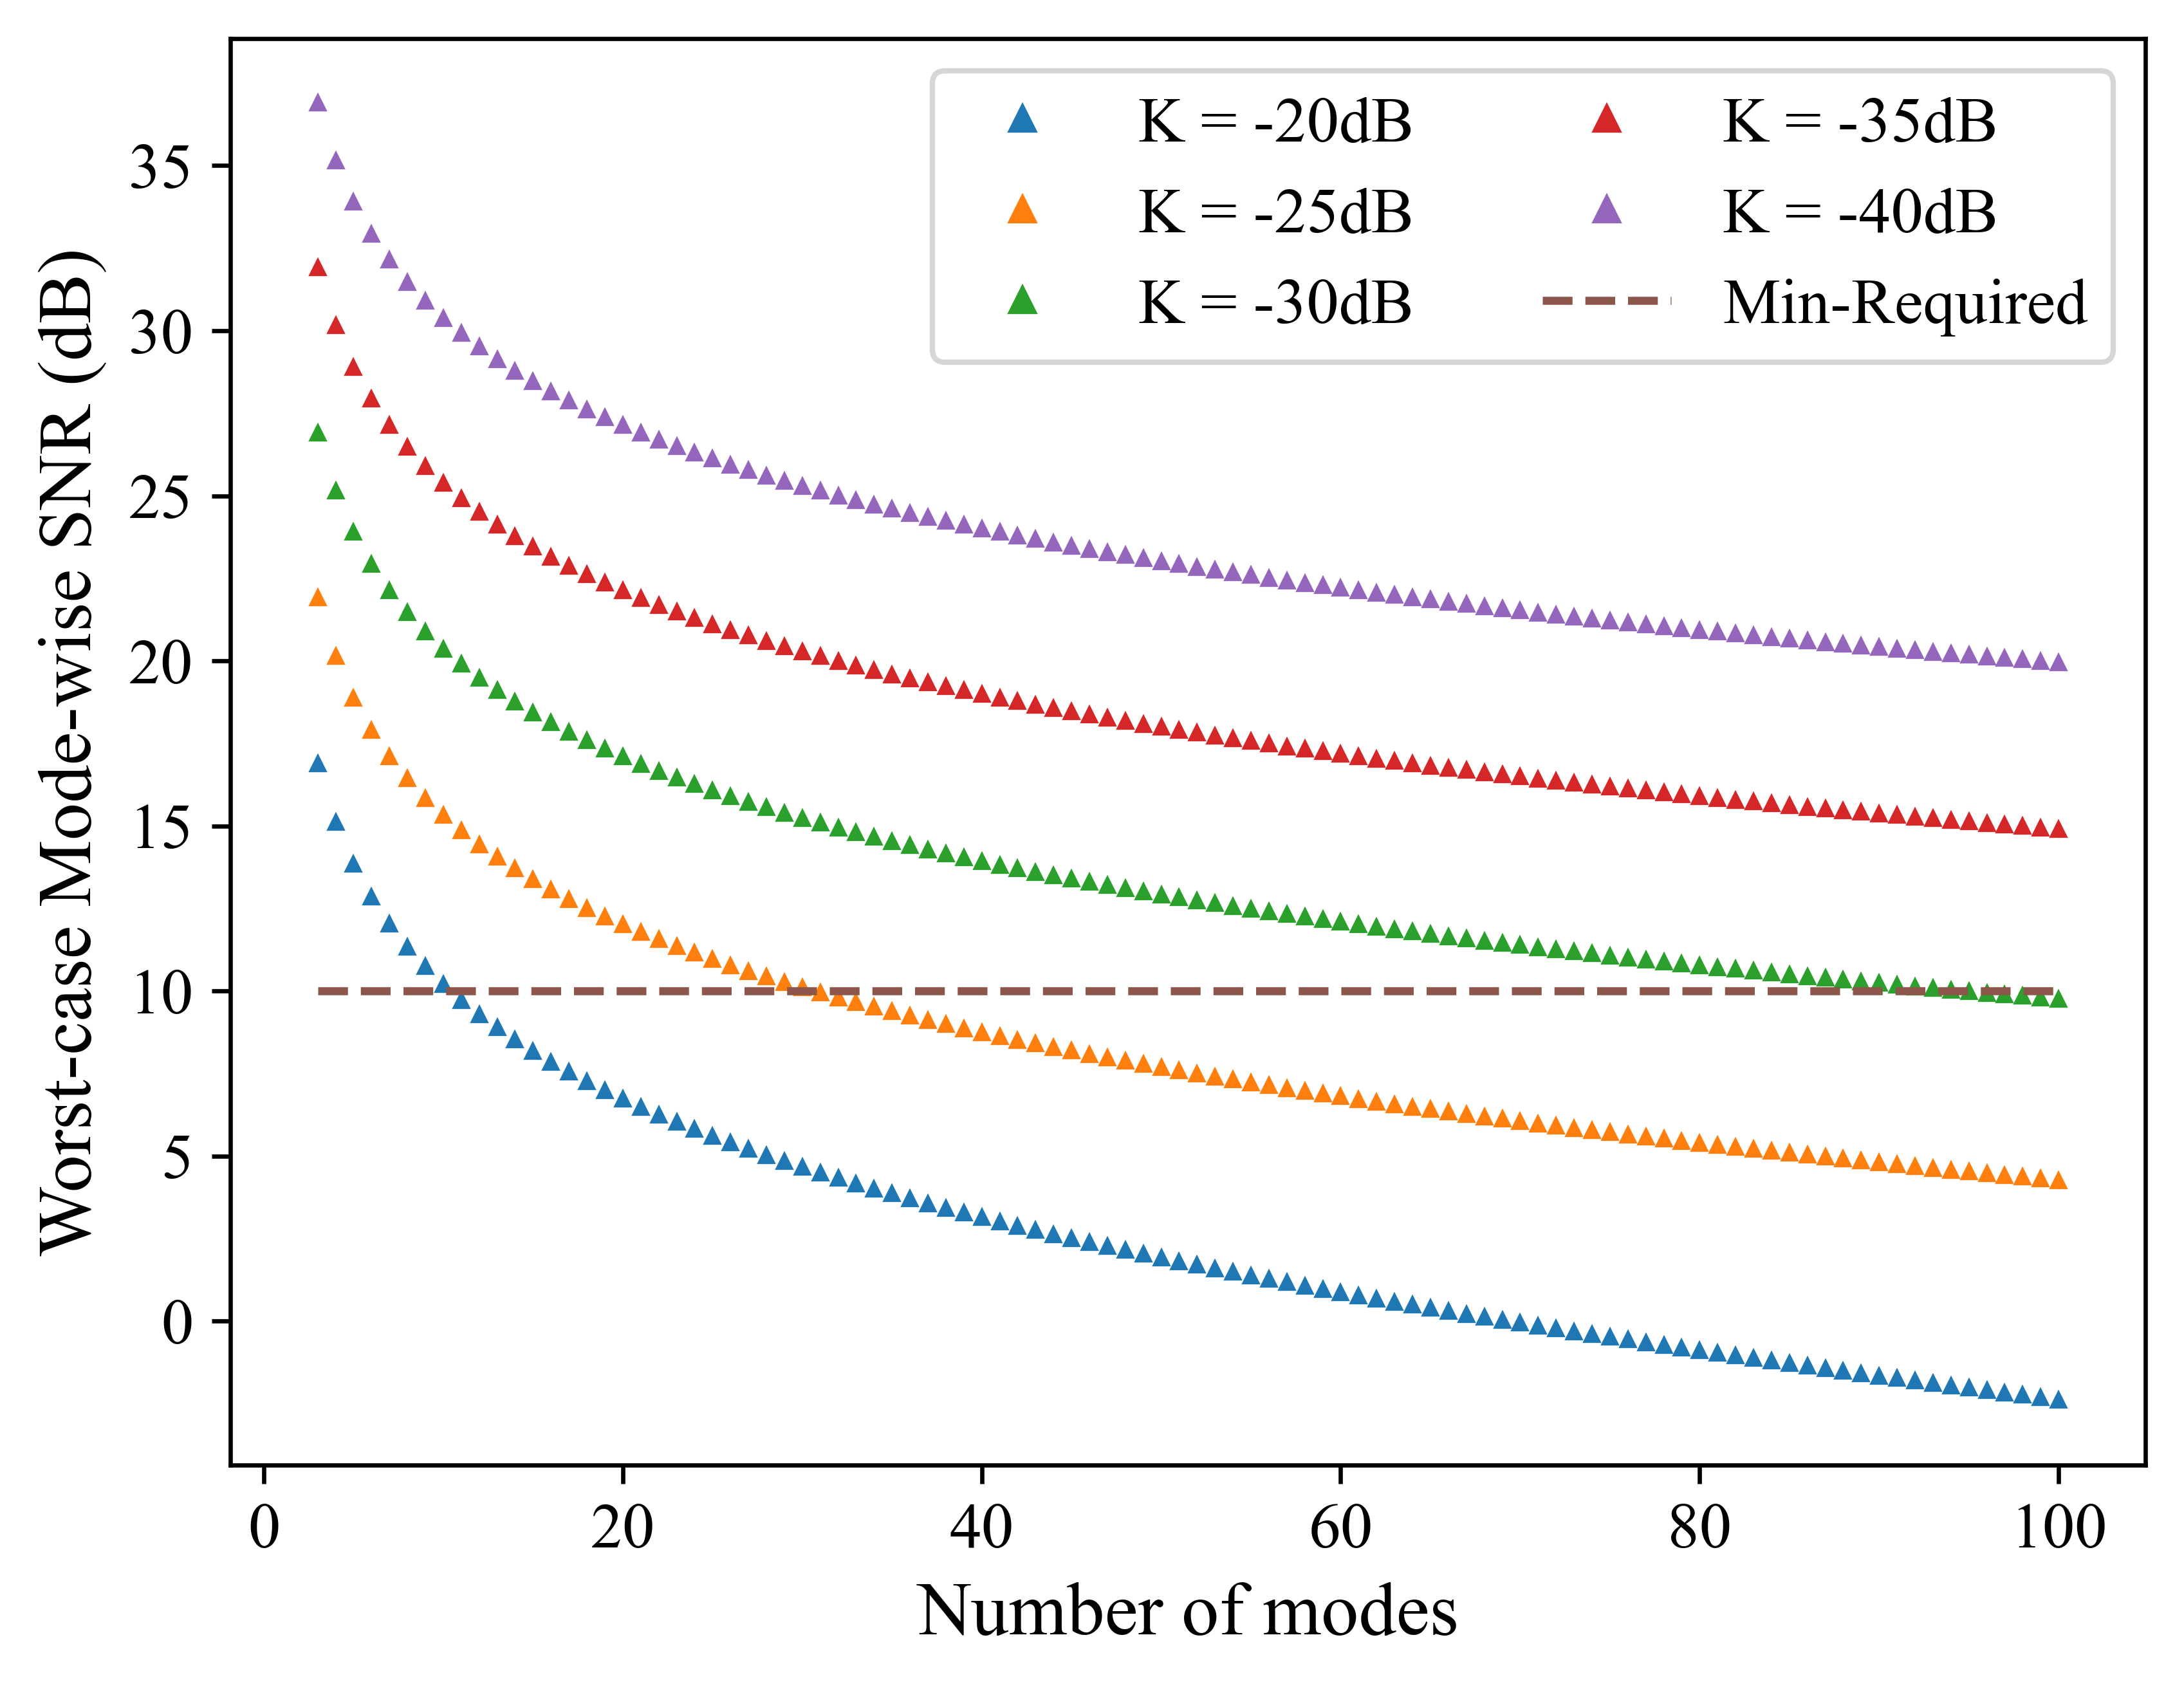

In [166]:
# System Configurations and Parameters
NUM_MODE = 101
Lp_dB = -0.01
Lc_dB = -0.1
ER_dB = [20, 25, 30, 35, 40]

# Buffers to store the data for drawings
signals = np.zeros((NUM_MODE, 1))
noises = np.zeros((NUM_MODE, 1))

# Setup for Matplotlib
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "normal"
plt.rcParams["font.size"] = 12
plt.figure(dpi=600)
x = range(3, NUM_MODE)

# Sweep Parameters
for er in ER_dB:
    K_dB = -er
    for i in range(3, NUM_MODE):
        mat = np.fliplr(np.eye(i))
        [u, s, v] = np.linalg.svd(mat, full_matrices=True)
        [p, t, a] = decompose_clements(u, block='mzi')
        [E_signal, P_crosstalk] = reconstruct_clements_pnn(p, t, a, 
                         np.ones((i, 1), dtype=np.complex128), 
                         np.zeros((i, 1), dtype=np.complex128),
                         block='mzi', Lp_dB=Lp_dB, Lc_dB=Lc_dB, K1_dB=K_dB, K2_dB=K_dB)
        signals[i] = np.abs(np.sum(np.square(E_signal).squeeze()))
        noises[i] = np.abs(np.sum(P_crosstalk.squeeze()))
        
    y1 = signals[3:NUM_MODE]
    y2 = noises[3:NUM_MODE]
    snr = y1 / y2
    snr_dB = 10 * np.log10(snr)
    plt.plot(x, snr_dB, '^', markersize=2)
    
# Annotate Setup
baseline = np.ones_like(x) * 10
plt.plot(x, baseline, '--')
    
plt.xlabel('Number of modes', fontsize=14)
plt.ylabel('Worst-case Mode-wise SNR (dB)', fontsize=14)

notes = [f"K = -{e}dB" for e in ER_dB]
notes.append('Min-Required')
plt.legend(notes, ncol=2, markerscale=2.0)
plt.show()

### Comparison with Fidelity

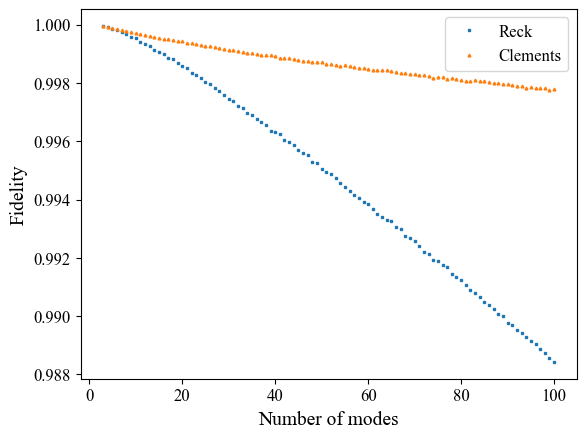

In [21]:
# System Configurations and Parameters
NUM_MODE = 101
Lp_dB = -0.01
Lc_dB = -0.1
COUNT = 10 #Setting 100 will Need 1.89 Hours to run

# Buffers to store the data for drawings
fidelity = np.zeros((NUM_MODE, 1))

# Setup for Matplotlib
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "normal"
plt.rcParams["font.size"] = 12
plt.figure()
x = range(3, NUM_MODE)

# Sweep Parameters [Reck]
for i in range(3, NUM_MODE):
    statistic = 0.0
    for _ in range(COUNT):
        mat = np.random.randn(i, i)
        [u, s, v] = np.linalg.svd(mat, full_matrices=True)
        [p, t, a] = decompose_reck(u, block='mzi')
        Ue = reconstruct_reck(p, t, a, block='mzi', Lp_dB=Lp_dB, Lc_dB=Lc_dB)
        statistic += np.abs(np.trace(u.conj().T @ Ue) / np.sqrt(i * np.trace(Ue.conj().T @ Ue))) ** 2
    fidelity[i] = statistic / COUNT

# Annotate Setup
y = fidelity[3:NUM_MODE]
plt.plot(x, y, 's', markersize=2)

# Sweep Parameters [Clements]
for i in range(3, NUM_MODE):
    statistic = 0.0
    for _ in range(COUNT):
        mat = np.random.randn(i, i)
        [u, s, v] = np.linalg.svd(mat, full_matrices=True)
        [p, t, a] = decompose_clements(u, block='mzi')
        Ue = reconstruct_clements(p, t, a, block='mzi', Lp_dB=Lp_dB, Lc_dB=Lc_dB)
        statistic += np.abs(np.trace(u.conj().T @ Ue) / np.sqrt(i * np.trace(Ue.conj().T @ Ue))) ** 2
    fidelity[i] = statistic / COUNT

# Annotate Setup
y = fidelity[3:NUM_MODE]
plt.plot(x, y, '^', markersize=2)

plt.xlabel('Number of modes', fontsize=14)
plt.ylabel('Fidelity', fontsize=14)
plt.legend(['Reck', 'Clements'])

plt.show()

## Experimental Verification

### Photo-Detectors & Attenuators & Nonlinear-Activations

In [20]:
def photo_detector(E_signal, P_crosstalk, 
                   dynamic_ranges=[-16, 16], precision_bitdepth=16):
    
    nums = 2**precision_bitdepth
    bins = np.linspace(*dynamic_ranges, num=nums)
    amps = E_signal + np.sqrt(P_crosstalk) * np.exp(1j * np.random.random() * 2 * np.pi)
    inds = np.digitize(np.real(amps), bins)
    inds[inds>=nums] = nums - 1
    return bins[inds]
    

def diagonal_attenuator(E_signal, diagonal_factor, num_output=None):
    if E_signal.size >= diagonal_factor.size:
        vec = E_signal.squeeze()[:diagonal_factor.size] * diagonal_factor
    else:
        vec = E_signal.squeeze() * diagonal_factor[:E_signal.size]
        
    vec = vec.astype(np.complex128)
    
    if num_output is not None:
        if vec.size >= num_output:
            return vec[:num_output][:, np.newaxis]
        else:
            padding = np.zeros(num_output, dtype=np.complex128)
            padding[:vec.size] = vec
            return padding[:, np.newaxis]
    else:
        return vec[:, np.newaxis]


def nonlinear_tanh(x):
    return np.tanh(x).astype(np.complex128)


def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

### Weight Extraction from LeNet-5 

In [21]:
pnn_mat1 = model.classifier[0].weight.detach().numpy().T
[u1, s1, v1] = np.linalg.svd(pnn_mat1, full_matrices=True)
[p1u, t1u, a1u] = decompose_clements(u1.conj().T, block='mzi')
[p1v, t1v, a1v] = decompose_clements(v1.conj().T, block='mzi')

pnn_mat2 = model.classifier[2].weight.detach().numpy().T
[u2, s2, v2] = np.linalg.svd(pnn_mat2, full_matrices=True)
[p2u, t2u, a2u] = decompose_clements(u2.conj().T, block='mzi')
[p2v, t2v, a2v] = decompose_clements(v2.conj().T, block='mzi')

### One Iteration of Inference

In [24]:
# Parameters
Lp_dB = -0.01
Lc_dB = -0.1
K1_dB = -25
K2_dB = -25

X_samples = torch.ones(1,1,32,32)
Z_features = model.feature_extractor(X_samples).detach().numpy()
pnn_inputs = Z_features.squeeze()[:,np.newaxis].astype(np.complex128)

# Mat 1 - U
[E_sig, P_xtalk] = reconstruct_clements_pnn(p1u, t1u, a1u, 
                         pnn_inputs,
                         np.zeros_like(pnn_inputs, dtype=np.complex128),
                         block='mzi',
                         Lp_dB=Lp_dB, Lc_dB=Lc_dB, K1_dB=K1_dB, K2_dB=K2_dB)
E_sig = photo_detector(E_sig, P_xtalk)

# Mat 1 - S
E_sig = diagonal_attenuator(E_sig, s1, num_output=v1.shape[0])

# Mat 1 - V
[E_sig, P_xtalk] = reconstruct_clements_pnn(p1v, t1v, a1v, 
                         E_sig,
                         np.zeros_like(E_sig, dtype=np.complex128),
                         block='mzi',
                         Lp_dB=Lp_dB, Lc_dB=Lc_dB, K1_dB=K1_dB, K2_dB=K2_dB)
E_sig = photo_detector(E_sig, P_xtalk)

# Activation - Tanh
E_sig = nonlinear_tanh(E_sig)

# Mat 2 - U
[E_sig, P_xtalk] = reconstruct_clements_pnn(p2u, t2u, a2u, 
                         E_sig,
                         np.zeros_like(E_sig, dtype=np.complex128),
                         block='mzi',
                         Lp_dB=Lp_dB, Lc_dB=Lc_dB, K1_dB=K1_dB, K2_dB=K2_dB)
E_sig = photo_detector(E_sig, P_xtalk)

# Mat 2 - S
E_sig = diagonal_attenuator(E_sig, s2, num_output=v2.shape[0])

# Mat 2 - V
[E_sig, P_xtalk] = reconstruct_clements_pnn(p2v, t2v, a2v, 
                         E_sig,
                         np.zeros_like(E_sig, dtype=np.complex128),
                         block='mzi',
                         Lp_dB=Lp_dB, Lc_dB=Lc_dB, K1_dB=K1_dB, K2_dB=K2_dB)
E_sig = photo_detector(E_sig, P_xtalk)

# Softmax (prob: probability, pred: prediction)
prob = softmax(E_sig.astype(np.double))
pred = prob.argmax()

### Realization for PNN Class

In [22]:
class PNN:
    def __init__(self, matrix, Lp_dB=0, Lc_dB=0, K1_dB=-10000, K2_dB=-10000):
        [self.u, self.s, self.v] = np.linalg.svd(matrix, full_matrices=True)
        [self.p_u, self.t_u, self.a_u] = decompose_clements(self.u.conj().T, block='mzi')
        [self.p_v, self.t_v, self.a_v] = decompose_clements(self.v.conj().T, block='mzi')
        self.Lp_dB, self.Lc_dB = Lp_dB, Lc_dB
        self.K1_dB, self.K2_dB = K1_dB, K2_dB
        
    def __call__(self, inputs):
        pnn_inputs = inputs.squeeze()[:,np.newaxis].astype(np.complex128)
        [E_sig, P_xtalk] = reconstruct_clements_pnn(self.p_u, self.t_u, self.a_u, 
                                 pnn_inputs,
                                 np.zeros_like(pnn_inputs, dtype=np.complex128),
                                 block='mzi',
                                 Lp_dB=self.Lp_dB, Lc_dB=self.Lc_dB, K1_dB=self.K1_dB, K2_dB=self.K2_dB)
        E_sig = photo_detector(E_sig, P_xtalk)
        
        E_sig = diagonal_attenuator(E_sig, self.s, num_output=self.v.shape[0])
        P_xtalk = diagonal_attenuator(P_xtalk, self.s, num_output=self.v.shape[0])
        
        [E_sig, P_xtalk] = reconstruct_clements_pnn(self.p_v, self.t_v, self.a_v,
                                 E_sig,
                                 P_xtalk,
                                 block='mzi',
                                 Lp_dB=self.Lp_dB, Lc_dB=self.Lc_dB, K1_dB=self.K1_dB, K2_dB=self.K2_dB)
        E_sig = photo_detector(E_sig, P_xtalk)
        return E_sig

### Unit Test for PNN class

In [23]:
MAT_ROW = 20
MAT_COL = 20
REL_TOL = 1e-4
ABS_TOL = 1e-3

mat_test = np.random.rand(MAT_ROW, MAT_COL)
inputs = np.random.rand(MAT_ROW, 1)
pnn_test = PNN(mat_test)

print(f'PNN Test:\t{np.allclose(pnn_test(inputs), mat_test.T @ inputs, rtol=REL_TOL, atol=ABS_TOL)}\n')
print('[INFO] if OUTPUT is False, it might be caused by the dynamic_ranges of photo_detector.')
print(f'\n* PNN Output = \n{pnn_test(inputs)}\n\n* Reference Output = \n{mat_test.T @ inputs}\n')

PNN Test:	True

[INFO] if OUTPUT is False, it might be caused by the dynamic_ranges of photo_detector.

* PNN Output = 
[[3.50176242]
 [4.35675593]
 [4.39923705]
 [3.55352102]
 [4.59064622]
 [3.61992828]
 [4.23468376]
 [3.86504921]
 [4.81135271]
 [4.12286564]
 [3.57647059]
 [4.00909438]
 [4.47296864]
 [4.86115816]
 [3.64727245]
 [3.50078584]
 [3.64727245]
 [3.47392996]
 [5.05500877]
 [4.48371099]]

* Reference Output = 
[[3.50211876]
 [4.35670109]
 [4.3993899 ]
 [3.55392598]
 [4.5904619 ]
 [3.61932139]
 [4.23483187]
 [3.86535316]
 [4.81085766]
 [4.12331125]
 [3.57644191]
 [4.00922809]
 [4.47261107]
 [4.86134359]
 [3.64714641]
 [3.50093242]
 [3.64721265]
 [3.47406923]
 [5.05484835]
 [4.48373043]]



### Batch Evaluation

In [27]:
def pnn_evaluate(data_loader, model, device, pnn1, pnn2):
    
    model.eval()
    cnt = 0
    num_total = 0
    num_right = 0
    
    for X, Y_true in data_loader:
        cnt += 1
        X = X.to(device)
        Y_true = Y_true.to(device)
        
        Z_features = model.feature_extractor(X).detach().numpy()
        _, Y_prob = model(X)
        Y_pred = Y_prob.argmax(axis=1).detach().numpy()
        
        for i in range(len(Z_features)):
            pnn_inputs = Z_features[i].squeeze()[:,np.newaxis]
            Z = pnn1(pnn_inputs)
            Z = nonlinear_tanh(Z)
            Z = pnn2(Z)
            prob = softmax(Z)
            pred = prob.argmax()
            
            # print(f'Y_true = {Y_true[i]}, Y_pred = {Y_pred[i]}, PNN_pred = {pred}')
            
            if Y_true[i] == pred:
                num_right += 1
            num_total += 1
        
        print(f'[INFO] Progress: {cnt} / {len(data_loader)}; Accumulate: Correct: {num_right}, Total: {num_total}')
        
    return num_right, num_total

In [28]:
pnn1 = PNN(pnn_mat1)
pnn2 = PNN(pnn_mat2)

num_true, num_all = pnn_evaluate(valid_loader, model, DEVICE, pnn1, pnn2)
print('[SUMMARY] Test Accuracy:\t {} / {} = {:.3f}'.format(num_true, num_all, num_true/num_all*100))

[INFO] Progress: 1 / 313; Accumulate: Correct: 32, Total: 32
[INFO] Progress: 2 / 313; Accumulate: Correct: 64, Total: 64
[INFO] Progress: 3 / 313; Accumulate: Correct: 96, Total: 96
[INFO] Progress: 4 / 313; Accumulate: Correct: 126, Total: 128
[INFO] Progress: 5 / 313; Accumulate: Correct: 157, Total: 160
[INFO] Progress: 6 / 313; Accumulate: Correct: 189, Total: 192
[INFO] Progress: 7 / 313; Accumulate: Correct: 221, Total: 224
[INFO] Progress: 8 / 313; Accumulate: Correct: 251, Total: 256
[INFO] Progress: 9 / 313; Accumulate: Correct: 283, Total: 288
[INFO] Progress: 10 / 313; Accumulate: Correct: 315, Total: 320
[INFO] Progress: 11 / 313; Accumulate: Correct: 345, Total: 352
[INFO] Progress: 12 / 313; Accumulate: Correct: 377, Total: 384
[INFO] Progress: 13 / 313; Accumulate: Correct: 409, Total: 416
[INFO] Progress: 14 / 313; Accumulate: Correct: 440, Total: 448
[INFO] Progress: 15 / 313; Accumulate: Correct: 471, Total: 480
[INFO] Progress: 16 / 313; Accumulate: Correct: 502, To

[INFO] Progress: 126 / 313; Accumulate: Correct: 3939, Total: 4032
[INFO] Progress: 127 / 313; Accumulate: Correct: 3971, Total: 4064
[INFO] Progress: 128 / 313; Accumulate: Correct: 4001, Total: 4096
[INFO] Progress: 129 / 313; Accumulate: Correct: 4033, Total: 4128
[INFO] Progress: 130 / 313; Accumulate: Correct: 4064, Total: 4160
[INFO] Progress: 131 / 313; Accumulate: Correct: 4095, Total: 4192
[INFO] Progress: 132 / 313; Accumulate: Correct: 4127, Total: 4224
[INFO] Progress: 133 / 313; Accumulate: Correct: 4157, Total: 4256
[INFO] Progress: 134 / 313; Accumulate: Correct: 4188, Total: 4288
[INFO] Progress: 135 / 313; Accumulate: Correct: 4218, Total: 4320
[INFO] Progress: 136 / 313; Accumulate: Correct: 4250, Total: 4352
[INFO] Progress: 137 / 313; Accumulate: Correct: 4280, Total: 4384
[INFO] Progress: 138 / 313; Accumulate: Correct: 4310, Total: 4416
[INFO] Progress: 139 / 313; Accumulate: Correct: 4342, Total: 4448
[INFO] Progress: 140 / 313; Accumulate: Correct: 4374, Total: 

[INFO] Progress: 249 / 313; Accumulate: Correct: 7822, Total: 7968
[INFO] Progress: 250 / 313; Accumulate: Correct: 7854, Total: 8000
[INFO] Progress: 251 / 313; Accumulate: Correct: 7886, Total: 8032
[INFO] Progress: 252 / 313; Accumulate: Correct: 7917, Total: 8064
[INFO] Progress: 253 / 313; Accumulate: Correct: 7947, Total: 8096
[INFO] Progress: 254 / 313; Accumulate: Correct: 7979, Total: 8128
[INFO] Progress: 255 / 313; Accumulate: Correct: 8011, Total: 8160
[INFO] Progress: 256 / 313; Accumulate: Correct: 8042, Total: 8192
[INFO] Progress: 257 / 313; Accumulate: Correct: 8074, Total: 8224
[INFO] Progress: 258 / 313; Accumulate: Correct: 8106, Total: 8256
[INFO] Progress: 259 / 313; Accumulate: Correct: 8138, Total: 8288
[INFO] Progress: 260 / 313; Accumulate: Correct: 8170, Total: 8320
[INFO] Progress: 261 / 313; Accumulate: Correct: 8201, Total: 8352
[INFO] Progress: 262 / 313; Accumulate: Correct: 8233, Total: 8384
[INFO] Progress: 263 / 313; Accumulate: Correct: 8263, Total: 

### Sweep Parameters to Investigate the Impacts of Crosstalk on PNN Inference

In [29]:
# Coefficient Setup
crosstalk_coefficients = [-40, -35, -30, -25, -20]
Lp_dB = -0.01
Lc_dB = [-0.1, -0.2, -0.3]

test_accuracies = np.zeros((len(Lc_dB), len(crosstalk_coefficients)), dtype=np.double)

# Sweep Parameters (Loss-Only)
pnn1 = PNN(pnn_mat1, Lp_dB=Lp_dB, Lc_dB=Lc_dB[0])
pnn2 = PNN(pnn_mat2, Lp_dB=Lp_dB, Lc_dB=Lc_dB[0])
num_true, num_all = pnn_evaluate(valid_loader, model, DEVICE, pnn1, pnn2)
acc_lossonly = num_true / num_all * 100.0

# Sweep Parameters (Crosstalk-aware)
for i, loss_coef in enumerate(Lc_dB):
    for j, xtalk_coef in enumerate(crosstalk_coefficients):
        pnn1 = PNN(pnn_mat1, Lp_dB=Lp_dB, Lc_dB=loss_coef, K1_dB=xtalk_coef, K2_dB=xtalk_coef)
        pnn2 = PNN(pnn_mat2, Lp_dB=Lp_dB, Lc_dB=loss_coef, K1_dB=xtalk_coef, K2_dB=xtalk_coef)
        num_true, num_all = pnn_evaluate(valid_loader, model, DEVICE, pnn1, pnn2)
        test_accuracies[i, j] = num_true / num_all * 100.0
    
# Drawing Variable Setup
x = crosstalk_coefficients
y = test_accuracies
y_lossonly = np.ones(len(crosstalk_coefficients)) * acc_lossonly

[INFO] Progress: 1 / 313; Accumulate: Correct: 32, Total: 32
[INFO] Progress: 2 / 313; Accumulate: Correct: 63, Total: 64
[INFO] Progress: 3 / 313; Accumulate: Correct: 95, Total: 96
[INFO] Progress: 4 / 313; Accumulate: Correct: 125, Total: 128
[INFO] Progress: 5 / 313; Accumulate: Correct: 156, Total: 160
[INFO] Progress: 6 / 313; Accumulate: Correct: 188, Total: 192
[INFO] Progress: 7 / 313; Accumulate: Correct: 220, Total: 224
[INFO] Progress: 8 / 313; Accumulate: Correct: 250, Total: 256
[INFO] Progress: 9 / 313; Accumulate: Correct: 282, Total: 288
[INFO] Progress: 10 / 313; Accumulate: Correct: 314, Total: 320
[INFO] Progress: 11 / 313; Accumulate: Correct: 344, Total: 352
[INFO] Progress: 12 / 313; Accumulate: Correct: 375, Total: 384
[INFO] Progress: 13 / 313; Accumulate: Correct: 407, Total: 416
[INFO] Progress: 14 / 313; Accumulate: Correct: 438, Total: 448
[INFO] Progress: 15 / 313; Accumulate: Correct: 469, Total: 480
[INFO] Progress: 16 / 313; Accumulate: Correct: 500, To

[INFO] Progress: 126 / 313; Accumulate: Correct: 3931, Total: 4032
[INFO] Progress: 127 / 313; Accumulate: Correct: 3963, Total: 4064
[INFO] Progress: 128 / 313; Accumulate: Correct: 3994, Total: 4096
[INFO] Progress: 129 / 313; Accumulate: Correct: 4025, Total: 4128
[INFO] Progress: 130 / 313; Accumulate: Correct: 4057, Total: 4160
[INFO] Progress: 131 / 313; Accumulate: Correct: 4088, Total: 4192
[INFO] Progress: 132 / 313; Accumulate: Correct: 4120, Total: 4224
[INFO] Progress: 133 / 313; Accumulate: Correct: 4150, Total: 4256
[INFO] Progress: 134 / 313; Accumulate: Correct: 4181, Total: 4288
[INFO] Progress: 135 / 313; Accumulate: Correct: 4211, Total: 4320
[INFO] Progress: 136 / 313; Accumulate: Correct: 4243, Total: 4352
[INFO] Progress: 137 / 313; Accumulate: Correct: 4273, Total: 4384
[INFO] Progress: 138 / 313; Accumulate: Correct: 4304, Total: 4416
[INFO] Progress: 139 / 313; Accumulate: Correct: 4336, Total: 4448
[INFO] Progress: 140 / 313; Accumulate: Correct: 4368, Total: 

[INFO] Progress: 249 / 313; Accumulate: Correct: 7810, Total: 7968
[INFO] Progress: 250 / 313; Accumulate: Correct: 7842, Total: 8000
[INFO] Progress: 251 / 313; Accumulate: Correct: 7874, Total: 8032
[INFO] Progress: 252 / 313; Accumulate: Correct: 7905, Total: 8064
[INFO] Progress: 253 / 313; Accumulate: Correct: 7935, Total: 8096
[INFO] Progress: 254 / 313; Accumulate: Correct: 7967, Total: 8128
[INFO] Progress: 255 / 313; Accumulate: Correct: 7999, Total: 8160
[INFO] Progress: 256 / 313; Accumulate: Correct: 8030, Total: 8192
[INFO] Progress: 257 / 313; Accumulate: Correct: 8062, Total: 8224
[INFO] Progress: 258 / 313; Accumulate: Correct: 8094, Total: 8256
[INFO] Progress: 259 / 313; Accumulate: Correct: 8126, Total: 8288
[INFO] Progress: 260 / 313; Accumulate: Correct: 8158, Total: 8320
[INFO] Progress: 261 / 313; Accumulate: Correct: 8189, Total: 8352
[INFO] Progress: 262 / 313; Accumulate: Correct: 8221, Total: 8384
[INFO] Progress: 263 / 313; Accumulate: Correct: 8251, Total: 

[INFO] Progress: 61 / 313; Accumulate: Correct: 1907, Total: 1952
[INFO] Progress: 62 / 313; Accumulate: Correct: 1939, Total: 1984
[INFO] Progress: 63 / 313; Accumulate: Correct: 1971, Total: 2016
[INFO] Progress: 64 / 313; Accumulate: Correct: 2002, Total: 2048
[INFO] Progress: 65 / 313; Accumulate: Correct: 2033, Total: 2080
[INFO] Progress: 66 / 313; Accumulate: Correct: 2063, Total: 2112
[INFO] Progress: 67 / 313; Accumulate: Correct: 2093, Total: 2144
[INFO] Progress: 68 / 313; Accumulate: Correct: 2125, Total: 2176
[INFO] Progress: 69 / 313; Accumulate: Correct: 2157, Total: 2208
[INFO] Progress: 70 / 313; Accumulate: Correct: 2189, Total: 2240
[INFO] Progress: 71 / 313; Accumulate: Correct: 2221, Total: 2272
[INFO] Progress: 72 / 313; Accumulate: Correct: 2251, Total: 2304
[INFO] Progress: 73 / 313; Accumulate: Correct: 2282, Total: 2336
[INFO] Progress: 74 / 313; Accumulate: Correct: 2314, Total: 2368
[INFO] Progress: 75 / 313; Accumulate: Correct: 2343, Total: 2400
[INFO] Pro

[INFO] Progress: 184 / 313; Accumulate: Correct: 5759, Total: 5888
[INFO] Progress: 185 / 313; Accumulate: Correct: 5791, Total: 5920
[INFO] Progress: 186 / 313; Accumulate: Correct: 5822, Total: 5952
[INFO] Progress: 187 / 313; Accumulate: Correct: 5852, Total: 5984
[INFO] Progress: 188 / 313; Accumulate: Correct: 5884, Total: 6016
[INFO] Progress: 189 / 313; Accumulate: Correct: 5916, Total: 6048
[INFO] Progress: 190 / 313; Accumulate: Correct: 5948, Total: 6080
[INFO] Progress: 191 / 313; Accumulate: Correct: 5980, Total: 6112
[INFO] Progress: 192 / 313; Accumulate: Correct: 6012, Total: 6144
[INFO] Progress: 193 / 313; Accumulate: Correct: 6043, Total: 6176
[INFO] Progress: 194 / 313; Accumulate: Correct: 6075, Total: 6208
[INFO] Progress: 195 / 313; Accumulate: Correct: 6107, Total: 6240
[INFO] Progress: 196 / 313; Accumulate: Correct: 6139, Total: 6272
[INFO] Progress: 197 / 313; Accumulate: Correct: 6171, Total: 6304
[INFO] Progress: 198 / 313; Accumulate: Correct: 6203, Total: 

[INFO] Progress: 307 / 313; Accumulate: Correct: 9644, Total: 9824
[INFO] Progress: 308 / 313; Accumulate: Correct: 9674, Total: 9856
[INFO] Progress: 309 / 313; Accumulate: Correct: 9705, Total: 9888
[INFO] Progress: 310 / 313; Accumulate: Correct: 9736, Total: 9920
[INFO] Progress: 311 / 313; Accumulate: Correct: 9767, Total: 9952
[INFO] Progress: 312 / 313; Accumulate: Correct: 9799, Total: 9984
[INFO] Progress: 313 / 313; Accumulate: Correct: 9815, Total: 10000
[INFO] Progress: 1 / 313; Accumulate: Correct: 32, Total: 32
[INFO] Progress: 2 / 313; Accumulate: Correct: 63, Total: 64
[INFO] Progress: 3 / 313; Accumulate: Correct: 95, Total: 96
[INFO] Progress: 4 / 313; Accumulate: Correct: 125, Total: 128
[INFO] Progress: 5 / 313; Accumulate: Correct: 156, Total: 160
[INFO] Progress: 6 / 313; Accumulate: Correct: 188, Total: 192
[INFO] Progress: 7 / 313; Accumulate: Correct: 220, Total: 224
[INFO] Progress: 8 / 313; Accumulate: Correct: 250, Total: 256
[INFO] Progress: 9 / 313; Accumu

[INFO] Progress: 119 / 313; Accumulate: Correct: 3718, Total: 3808
[INFO] Progress: 120 / 313; Accumulate: Correct: 3749, Total: 3840
[INFO] Progress: 121 / 313; Accumulate: Correct: 3781, Total: 3872
[INFO] Progress: 122 / 313; Accumulate: Correct: 3813, Total: 3904
[INFO] Progress: 123 / 313; Accumulate: Correct: 3845, Total: 3936
[INFO] Progress: 124 / 313; Accumulate: Correct: 3876, Total: 3968
[INFO] Progress: 125 / 313; Accumulate: Correct: 3907, Total: 4000
[INFO] Progress: 126 / 313; Accumulate: Correct: 3938, Total: 4032
[INFO] Progress: 127 / 313; Accumulate: Correct: 3970, Total: 4064
[INFO] Progress: 128 / 313; Accumulate: Correct: 4000, Total: 4096
[INFO] Progress: 129 / 313; Accumulate: Correct: 4031, Total: 4128
[INFO] Progress: 130 / 313; Accumulate: Correct: 4063, Total: 4160
[INFO] Progress: 131 / 313; Accumulate: Correct: 4094, Total: 4192
[INFO] Progress: 132 / 313; Accumulate: Correct: 4126, Total: 4224
[INFO] Progress: 133 / 313; Accumulate: Correct: 4155, Total: 

[INFO] Progress: 242 / 313; Accumulate: Correct: 7592, Total: 7744
[INFO] Progress: 243 / 313; Accumulate: Correct: 7624, Total: 7776
[INFO] Progress: 244 / 313; Accumulate: Correct: 7655, Total: 7808
[INFO] Progress: 245 / 313; Accumulate: Correct: 7687, Total: 7840
[INFO] Progress: 246 / 313; Accumulate: Correct: 7717, Total: 7872
[INFO] Progress: 247 / 313; Accumulate: Correct: 7748, Total: 7904
[INFO] Progress: 248 / 313; Accumulate: Correct: 7779, Total: 7936
[INFO] Progress: 249 / 313; Accumulate: Correct: 7811, Total: 7968
[INFO] Progress: 250 / 313; Accumulate: Correct: 7843, Total: 8000
[INFO] Progress: 251 / 313; Accumulate: Correct: 7875, Total: 8032
[INFO] Progress: 252 / 313; Accumulate: Correct: 7906, Total: 8064
[INFO] Progress: 253 / 313; Accumulate: Correct: 7936, Total: 8096
[INFO] Progress: 254 / 313; Accumulate: Correct: 7968, Total: 8128
[INFO] Progress: 255 / 313; Accumulate: Correct: 8000, Total: 8160
[INFO] Progress: 256 / 313; Accumulate: Correct: 8031, Total: 

[INFO] Progress: 54 / 313; Accumulate: Correct: 1680, Total: 1728
[INFO] Progress: 55 / 313; Accumulate: Correct: 1711, Total: 1760
[INFO] Progress: 56 / 313; Accumulate: Correct: 1742, Total: 1792
[INFO] Progress: 57 / 313; Accumulate: Correct: 1774, Total: 1824
[INFO] Progress: 58 / 313; Accumulate: Correct: 1805, Total: 1856
[INFO] Progress: 59 / 313; Accumulate: Correct: 1836, Total: 1888
[INFO] Progress: 60 / 313; Accumulate: Correct: 1866, Total: 1920
[INFO] Progress: 61 / 313; Accumulate: Correct: 1897, Total: 1952
[INFO] Progress: 62 / 313; Accumulate: Correct: 1929, Total: 1984
[INFO] Progress: 63 / 313; Accumulate: Correct: 1960, Total: 2016
[INFO] Progress: 64 / 313; Accumulate: Correct: 1989, Total: 2048
[INFO] Progress: 65 / 313; Accumulate: Correct: 2020, Total: 2080
[INFO] Progress: 66 / 313; Accumulate: Correct: 2050, Total: 2112
[INFO] Progress: 67 / 313; Accumulate: Correct: 2078, Total: 2144
[INFO] Progress: 68 / 313; Accumulate: Correct: 2110, Total: 2176
[INFO] Pro

[INFO] Progress: 177 / 313; Accumulate: Correct: 5505, Total: 5664
[INFO] Progress: 178 / 313; Accumulate: Correct: 5535, Total: 5696
[INFO] Progress: 179 / 313; Accumulate: Correct: 5567, Total: 5728
[INFO] Progress: 180 / 313; Accumulate: Correct: 5599, Total: 5760
[INFO] Progress: 181 / 313; Accumulate: Correct: 5631, Total: 5792
[INFO] Progress: 182 / 313; Accumulate: Correct: 5663, Total: 5824
[INFO] Progress: 183 / 313; Accumulate: Correct: 5695, Total: 5856
[INFO] Progress: 184 / 313; Accumulate: Correct: 5727, Total: 5888
[INFO] Progress: 185 / 313; Accumulate: Correct: 5759, Total: 5920
[INFO] Progress: 186 / 313; Accumulate: Correct: 5790, Total: 5952
[INFO] Progress: 187 / 313; Accumulate: Correct: 5820, Total: 5984
[INFO] Progress: 188 / 313; Accumulate: Correct: 5851, Total: 6016
[INFO] Progress: 189 / 313; Accumulate: Correct: 5883, Total: 6048
[INFO] Progress: 190 / 313; Accumulate: Correct: 5914, Total: 6080
[INFO] Progress: 191 / 313; Accumulate: Correct: 5945, Total: 

[INFO] Progress: 300 / 313; Accumulate: Correct: 9381, Total: 9600
[INFO] Progress: 301 / 313; Accumulate: Correct: 9412, Total: 9632
[INFO] Progress: 302 / 313; Accumulate: Correct: 9443, Total: 9664
[INFO] Progress: 303 / 313; Accumulate: Correct: 9473, Total: 9696
[INFO] Progress: 304 / 313; Accumulate: Correct: 9504, Total: 9728
[INFO] Progress: 305 / 313; Accumulate: Correct: 9532, Total: 9760
[INFO] Progress: 306 / 313; Accumulate: Correct: 9562, Total: 9792
[INFO] Progress: 307 / 313; Accumulate: Correct: 9593, Total: 9824
[INFO] Progress: 308 / 313; Accumulate: Correct: 9623, Total: 9856
[INFO] Progress: 309 / 313; Accumulate: Correct: 9655, Total: 9888
[INFO] Progress: 310 / 313; Accumulate: Correct: 9686, Total: 9920
[INFO] Progress: 311 / 313; Accumulate: Correct: 9716, Total: 9952
[INFO] Progress: 312 / 313; Accumulate: Correct: 9748, Total: 9984
[INFO] Progress: 313 / 313; Accumulate: Correct: 9763, Total: 10000
[INFO] Progress: 1 / 313; Accumulate: Correct: 30, Total: 32


[INFO] Progress: 112 / 313; Accumulate: Correct: 3387, Total: 3584
[INFO] Progress: 113 / 313; Accumulate: Correct: 3419, Total: 3616
[INFO] Progress: 114 / 313; Accumulate: Correct: 3450, Total: 3648
[INFO] Progress: 115 / 313; Accumulate: Correct: 3479, Total: 3680
[INFO] Progress: 116 / 313; Accumulate: Correct: 3509, Total: 3712
[INFO] Progress: 117 / 313; Accumulate: Correct: 3539, Total: 3744
[INFO] Progress: 118 / 313; Accumulate: Correct: 3570, Total: 3776
[INFO] Progress: 119 / 313; Accumulate: Correct: 3598, Total: 3808
[INFO] Progress: 120 / 313; Accumulate: Correct: 3628, Total: 3840
[INFO] Progress: 121 / 313; Accumulate: Correct: 3658, Total: 3872
[INFO] Progress: 122 / 313; Accumulate: Correct: 3690, Total: 3904
[INFO] Progress: 123 / 313; Accumulate: Correct: 3722, Total: 3936
[INFO] Progress: 124 / 313; Accumulate: Correct: 3751, Total: 3968
[INFO] Progress: 125 / 313; Accumulate: Correct: 3778, Total: 4000
[INFO] Progress: 126 / 313; Accumulate: Correct: 3808, Total: 

[INFO] Progress: 235 / 313; Accumulate: Correct: 7182, Total: 7520
[INFO] Progress: 236 / 313; Accumulate: Correct: 7214, Total: 7552
[INFO] Progress: 237 / 313; Accumulate: Correct: 7246, Total: 7584
[INFO] Progress: 238 / 313; Accumulate: Correct: 7276, Total: 7616
[INFO] Progress: 239 / 313; Accumulate: Correct: 7308, Total: 7648
[INFO] Progress: 240 / 313; Accumulate: Correct: 7340, Total: 7680
[INFO] Progress: 241 / 313; Accumulate: Correct: 7372, Total: 7712
[INFO] Progress: 242 / 313; Accumulate: Correct: 7404, Total: 7744
[INFO] Progress: 243 / 313; Accumulate: Correct: 7435, Total: 7776
[INFO] Progress: 244 / 313; Accumulate: Correct: 7465, Total: 7808
[INFO] Progress: 245 / 313; Accumulate: Correct: 7496, Total: 7840
[INFO] Progress: 246 / 313; Accumulate: Correct: 7524, Total: 7872
[INFO] Progress: 247 / 313; Accumulate: Correct: 7554, Total: 7904
[INFO] Progress: 248 / 313; Accumulate: Correct: 7584, Total: 7936
[INFO] Progress: 249 / 313; Accumulate: Correct: 7615, Total: 

[INFO] Progress: 47 / 313; Accumulate: Correct: 1067, Total: 1504
[INFO] Progress: 48 / 313; Accumulate: Correct: 1084, Total: 1536
[INFO] Progress: 49 / 313; Accumulate: Correct: 1104, Total: 1568
[INFO] Progress: 50 / 313; Accumulate: Correct: 1131, Total: 1600
[INFO] Progress: 51 / 313; Accumulate: Correct: 1157, Total: 1632
[INFO] Progress: 52 / 313; Accumulate: Correct: 1187, Total: 1664
[INFO] Progress: 53 / 313; Accumulate: Correct: 1214, Total: 1696
[INFO] Progress: 54 / 313; Accumulate: Correct: 1239, Total: 1728
[INFO] Progress: 55 / 313; Accumulate: Correct: 1260, Total: 1760
[INFO] Progress: 56 / 313; Accumulate: Correct: 1283, Total: 1792
[INFO] Progress: 57 / 313; Accumulate: Correct: 1304, Total: 1824
[INFO] Progress: 58 / 313; Accumulate: Correct: 1328, Total: 1856
[INFO] Progress: 59 / 313; Accumulate: Correct: 1357, Total: 1888
[INFO] Progress: 60 / 313; Accumulate: Correct: 1376, Total: 1920
[INFO] Progress: 61 / 313; Accumulate: Correct: 1403, Total: 1952
[INFO] Pro

[INFO] Progress: 171 / 313; Accumulate: Correct: 3895, Total: 5472
[INFO] Progress: 172 / 313; Accumulate: Correct: 3921, Total: 5504
[INFO] Progress: 173 / 313; Accumulate: Correct: 3946, Total: 5536
[INFO] Progress: 174 / 313; Accumulate: Correct: 3971, Total: 5568
[INFO] Progress: 175 / 313; Accumulate: Correct: 3991, Total: 5600
[INFO] Progress: 176 / 313; Accumulate: Correct: 4012, Total: 5632
[INFO] Progress: 177 / 313; Accumulate: Correct: 4040, Total: 5664
[INFO] Progress: 178 / 313; Accumulate: Correct: 4065, Total: 5696
[INFO] Progress: 179 / 313; Accumulate: Correct: 4087, Total: 5728
[INFO] Progress: 180 / 313; Accumulate: Correct: 4105, Total: 5760
[INFO] Progress: 181 / 313; Accumulate: Correct: 4132, Total: 5792
[INFO] Progress: 182 / 313; Accumulate: Correct: 4159, Total: 5824
[INFO] Progress: 183 / 313; Accumulate: Correct: 4178, Total: 5856
[INFO] Progress: 184 / 313; Accumulate: Correct: 4199, Total: 5888
[INFO] Progress: 185 / 313; Accumulate: Correct: 4218, Total: 

[INFO] Progress: 294 / 313; Accumulate: Correct: 6833, Total: 9408
[INFO] Progress: 295 / 313; Accumulate: Correct: 6858, Total: 9440
[INFO] Progress: 296 / 313; Accumulate: Correct: 6886, Total: 9472
[INFO] Progress: 297 / 313; Accumulate: Correct: 6912, Total: 9504
[INFO] Progress: 298 / 313; Accumulate: Correct: 6936, Total: 9536
[INFO] Progress: 299 / 313; Accumulate: Correct: 6960, Total: 9568
[INFO] Progress: 300 / 313; Accumulate: Correct: 6984, Total: 9600
[INFO] Progress: 301 / 313; Accumulate: Correct: 7005, Total: 9632
[INFO] Progress: 302 / 313; Accumulate: Correct: 7023, Total: 9664
[INFO] Progress: 303 / 313; Accumulate: Correct: 7046, Total: 9696
[INFO] Progress: 304 / 313; Accumulate: Correct: 7069, Total: 9728
[INFO] Progress: 305 / 313; Accumulate: Correct: 7087, Total: 9760
[INFO] Progress: 306 / 313; Accumulate: Correct: 7107, Total: 9792
[INFO] Progress: 307 / 313; Accumulate: Correct: 7128, Total: 9824
[INFO] Progress: 308 / 313; Accumulate: Correct: 7154, Total: 

[INFO] Progress: 106 / 313; Accumulate: Correct: 3295, Total: 3392
[INFO] Progress: 107 / 313; Accumulate: Correct: 3326, Total: 3424
[INFO] Progress: 108 / 313; Accumulate: Correct: 3357, Total: 3456
[INFO] Progress: 109 / 313; Accumulate: Correct: 3388, Total: 3488
[INFO] Progress: 110 / 313; Accumulate: Correct: 3419, Total: 3520
[INFO] Progress: 111 / 313; Accumulate: Correct: 3448, Total: 3552
[INFO] Progress: 112 / 313; Accumulate: Correct: 3479, Total: 3584
[INFO] Progress: 113 / 313; Accumulate: Correct: 3510, Total: 3616
[INFO] Progress: 114 / 313; Accumulate: Correct: 3542, Total: 3648
[INFO] Progress: 115 / 313; Accumulate: Correct: 3574, Total: 3680
[INFO] Progress: 116 / 313; Accumulate: Correct: 3605, Total: 3712
[INFO] Progress: 117 / 313; Accumulate: Correct: 3636, Total: 3744
[INFO] Progress: 118 / 313; Accumulate: Correct: 3666, Total: 3776
[INFO] Progress: 119 / 313; Accumulate: Correct: 3696, Total: 3808
[INFO] Progress: 120 / 313; Accumulate: Correct: 3727, Total: 

[INFO] Progress: 229 / 313; Accumulate: Correct: 7154, Total: 7328
[INFO] Progress: 230 / 313; Accumulate: Correct: 7186, Total: 7360
[INFO] Progress: 231 / 313; Accumulate: Correct: 7218, Total: 7392
[INFO] Progress: 232 / 313; Accumulate: Correct: 7250, Total: 7424
[INFO] Progress: 233 / 313; Accumulate: Correct: 7281, Total: 7456
[INFO] Progress: 234 / 313; Accumulate: Correct: 7311, Total: 7488
[INFO] Progress: 235 / 313; Accumulate: Correct: 7343, Total: 7520
[INFO] Progress: 236 / 313; Accumulate: Correct: 7375, Total: 7552
[INFO] Progress: 237 / 313; Accumulate: Correct: 7406, Total: 7584
[INFO] Progress: 238 / 313; Accumulate: Correct: 7438, Total: 7616
[INFO] Progress: 239 / 313; Accumulate: Correct: 7470, Total: 7648
[INFO] Progress: 240 / 313; Accumulate: Correct: 7502, Total: 7680
[INFO] Progress: 241 / 313; Accumulate: Correct: 7534, Total: 7712
[INFO] Progress: 242 / 313; Accumulate: Correct: 7566, Total: 7744
[INFO] Progress: 243 / 313; Accumulate: Correct: 7598, Total: 

[INFO] Progress: 41 / 313; Accumulate: Correct: 1278, Total: 1312
[INFO] Progress: 42 / 313; Accumulate: Correct: 1309, Total: 1344
[INFO] Progress: 43 / 313; Accumulate: Correct: 1341, Total: 1376
[INFO] Progress: 44 / 313; Accumulate: Correct: 1372, Total: 1408
[INFO] Progress: 45 / 313; Accumulate: Correct: 1403, Total: 1440
[INFO] Progress: 46 / 313; Accumulate: Correct: 1435, Total: 1472
[INFO] Progress: 47 / 313; Accumulate: Correct: 1466, Total: 1504
[INFO] Progress: 48 / 313; Accumulate: Correct: 1496, Total: 1536
[INFO] Progress: 49 / 313; Accumulate: Correct: 1526, Total: 1568
[INFO] Progress: 50 / 313; Accumulate: Correct: 1558, Total: 1600
[INFO] Progress: 51 / 313; Accumulate: Correct: 1590, Total: 1632
[INFO] Progress: 52 / 313; Accumulate: Correct: 1621, Total: 1664
[INFO] Progress: 53 / 313; Accumulate: Correct: 1652, Total: 1696
[INFO] Progress: 54 / 313; Accumulate: Correct: 1683, Total: 1728
[INFO] Progress: 55 / 313; Accumulate: Correct: 1713, Total: 1760
[INFO] Pro

[INFO] Progress: 165 / 313; Accumulate: Correct: 5136, Total: 5280
[INFO] Progress: 166 / 313; Accumulate: Correct: 5168, Total: 5312
[INFO] Progress: 167 / 313; Accumulate: Correct: 5199, Total: 5344
[INFO] Progress: 168 / 313; Accumulate: Correct: 5231, Total: 5376
[INFO] Progress: 169 / 313; Accumulate: Correct: 5263, Total: 5408
[INFO] Progress: 170 / 313; Accumulate: Correct: 5294, Total: 5440
[INFO] Progress: 171 / 313; Accumulate: Correct: 5325, Total: 5472
[INFO] Progress: 172 / 313; Accumulate: Correct: 5357, Total: 5504
[INFO] Progress: 173 / 313; Accumulate: Correct: 5389, Total: 5536
[INFO] Progress: 174 / 313; Accumulate: Correct: 5421, Total: 5568
[INFO] Progress: 175 / 313; Accumulate: Correct: 5451, Total: 5600
[INFO] Progress: 176 / 313; Accumulate: Correct: 5483, Total: 5632
[INFO] Progress: 177 / 313; Accumulate: Correct: 5514, Total: 5664
[INFO] Progress: 178 / 313; Accumulate: Correct: 5546, Total: 5696
[INFO] Progress: 179 / 313; Accumulate: Correct: 5578, Total: 

[INFO] Progress: 288 / 313; Accumulate: Correct: 9025, Total: 9216
[INFO] Progress: 289 / 313; Accumulate: Correct: 9056, Total: 9248
[INFO] Progress: 290 / 313; Accumulate: Correct: 9088, Total: 9280
[INFO] Progress: 291 / 313; Accumulate: Correct: 9120, Total: 9312
[INFO] Progress: 292 / 313; Accumulate: Correct: 9152, Total: 9344
[INFO] Progress: 293 / 313; Accumulate: Correct: 9184, Total: 9376
[INFO] Progress: 294 / 313; Accumulate: Correct: 9216, Total: 9408
[INFO] Progress: 295 / 313; Accumulate: Correct: 9248, Total: 9440
[INFO] Progress: 296 / 313; Accumulate: Correct: 9280, Total: 9472
[INFO] Progress: 297 / 313; Accumulate: Correct: 9311, Total: 9504
[INFO] Progress: 298 / 313; Accumulate: Correct: 9342, Total: 9536
[INFO] Progress: 299 / 313; Accumulate: Correct: 9374, Total: 9568
[INFO] Progress: 300 / 313; Accumulate: Correct: 9405, Total: 9600
[INFO] Progress: 301 / 313; Accumulate: Correct: 9437, Total: 9632
[INFO] Progress: 302 / 313; Accumulate: Correct: 9468, Total: 

[INFO] Progress: 100 / 313; Accumulate: Correct: 3084, Total: 3200
[INFO] Progress: 101 / 313; Accumulate: Correct: 3115, Total: 3232
[INFO] Progress: 102 / 313; Accumulate: Correct: 3147, Total: 3264
[INFO] Progress: 103 / 313; Accumulate: Correct: 3178, Total: 3296
[INFO] Progress: 104 / 313; Accumulate: Correct: 3210, Total: 3328
[INFO] Progress: 105 / 313; Accumulate: Correct: 3241, Total: 3360
[INFO] Progress: 106 / 313; Accumulate: Correct: 3273, Total: 3392
[INFO] Progress: 107 / 313; Accumulate: Correct: 3303, Total: 3424
[INFO] Progress: 108 / 313; Accumulate: Correct: 3333, Total: 3456
[INFO] Progress: 109 / 313; Accumulate: Correct: 3364, Total: 3488
[INFO] Progress: 110 / 313; Accumulate: Correct: 3395, Total: 3520
[INFO] Progress: 111 / 313; Accumulate: Correct: 3424, Total: 3552
[INFO] Progress: 112 / 313; Accumulate: Correct: 3455, Total: 3584
[INFO] Progress: 113 / 313; Accumulate: Correct: 3485, Total: 3616
[INFO] Progress: 114 / 313; Accumulate: Correct: 3517, Total: 

[INFO] Progress: 223 / 313; Accumulate: Correct: 6912, Total: 7136
[INFO] Progress: 224 / 313; Accumulate: Correct: 6944, Total: 7168
[INFO] Progress: 225 / 313; Accumulate: Correct: 6976, Total: 7200
[INFO] Progress: 226 / 313; Accumulate: Correct: 7008, Total: 7232
[INFO] Progress: 227 / 313; Accumulate: Correct: 7039, Total: 7264
[INFO] Progress: 228 / 313; Accumulate: Correct: 7071, Total: 7296
[INFO] Progress: 229 / 313; Accumulate: Correct: 7103, Total: 7328
[INFO] Progress: 230 / 313; Accumulate: Correct: 7135, Total: 7360
[INFO] Progress: 231 / 313; Accumulate: Correct: 7167, Total: 7392
[INFO] Progress: 232 / 313; Accumulate: Correct: 7199, Total: 7424
[INFO] Progress: 233 / 313; Accumulate: Correct: 7230, Total: 7456
[INFO] Progress: 234 / 313; Accumulate: Correct: 7260, Total: 7488
[INFO] Progress: 235 / 313; Accumulate: Correct: 7292, Total: 7520
[INFO] Progress: 236 / 313; Accumulate: Correct: 7324, Total: 7552
[INFO] Progress: 237 / 313; Accumulate: Correct: 7356, Total: 

[INFO] Progress: 34 / 313; Accumulate: Correct: 1025, Total: 1088
[INFO] Progress: 35 / 313; Accumulate: Correct: 1053, Total: 1120
[INFO] Progress: 36 / 313; Accumulate: Correct: 1085, Total: 1152
[INFO] Progress: 37 / 313; Accumulate: Correct: 1115, Total: 1184
[INFO] Progress: 38 / 313; Accumulate: Correct: 1145, Total: 1216
[INFO] Progress: 39 / 313; Accumulate: Correct: 1171, Total: 1248
[INFO] Progress: 40 / 313; Accumulate: Correct: 1200, Total: 1280
[INFO] Progress: 41 / 313; Accumulate: Correct: 1229, Total: 1312
[INFO] Progress: 42 / 313; Accumulate: Correct: 1260, Total: 1344
[INFO] Progress: 43 / 313; Accumulate: Correct: 1292, Total: 1376
[INFO] Progress: 44 / 313; Accumulate: Correct: 1322, Total: 1408
[INFO] Progress: 45 / 313; Accumulate: Correct: 1350, Total: 1440
[INFO] Progress: 46 / 313; Accumulate: Correct: 1380, Total: 1472
[INFO] Progress: 47 / 313; Accumulate: Correct: 1411, Total: 1504
[INFO] Progress: 48 / 313; Accumulate: Correct: 1439, Total: 1536
[INFO] Pro

[INFO] Progress: 158 / 313; Accumulate: Correct: 4723, Total: 5056
[INFO] Progress: 159 / 313; Accumulate: Correct: 4753, Total: 5088
[INFO] Progress: 160 / 313; Accumulate: Correct: 4784, Total: 5120
[INFO] Progress: 161 / 313; Accumulate: Correct: 4816, Total: 5152
[INFO] Progress: 162 / 313; Accumulate: Correct: 4847, Total: 5184
[INFO] Progress: 163 / 313; Accumulate: Correct: 4878, Total: 5216
[INFO] Progress: 164 / 313; Accumulate: Correct: 4910, Total: 5248
[INFO] Progress: 165 / 313; Accumulate: Correct: 4939, Total: 5280
[INFO] Progress: 166 / 313; Accumulate: Correct: 4970, Total: 5312
[INFO] Progress: 167 / 313; Accumulate: Correct: 5001, Total: 5344
[INFO] Progress: 168 / 313; Accumulate: Correct: 5032, Total: 5376
[INFO] Progress: 169 / 313; Accumulate: Correct: 5064, Total: 5408
[INFO] Progress: 170 / 313; Accumulate: Correct: 5095, Total: 5440
[INFO] Progress: 171 / 313; Accumulate: Correct: 5125, Total: 5472
[INFO] Progress: 172 / 313; Accumulate: Correct: 5156, Total: 

[INFO] Progress: 281 / 313; Accumulate: Correct: 8505, Total: 8992
[INFO] Progress: 282 / 313; Accumulate: Correct: 8533, Total: 9024
[INFO] Progress: 283 / 313; Accumulate: Correct: 8561, Total: 9056
[INFO] Progress: 284 / 313; Accumulate: Correct: 8591, Total: 9088
[INFO] Progress: 285 / 313; Accumulate: Correct: 8623, Total: 9120
[INFO] Progress: 286 / 313; Accumulate: Correct: 8654, Total: 9152
[INFO] Progress: 287 / 313; Accumulate: Correct: 8686, Total: 9184
[INFO] Progress: 288 / 313; Accumulate: Correct: 8717, Total: 9216
[INFO] Progress: 289 / 313; Accumulate: Correct: 8748, Total: 9248
[INFO] Progress: 290 / 313; Accumulate: Correct: 8780, Total: 9280
[INFO] Progress: 291 / 313; Accumulate: Correct: 8811, Total: 9312
[INFO] Progress: 292 / 313; Accumulate: Correct: 8842, Total: 9344
[INFO] Progress: 293 / 313; Accumulate: Correct: 8874, Total: 9376
[INFO] Progress: 294 / 313; Accumulate: Correct: 8906, Total: 9408
[INFO] Progress: 295 / 313; Accumulate: Correct: 8938, Total: 

[INFO] Progress: 94 / 313; Accumulate: Correct: 1951, Total: 3008
[INFO] Progress: 95 / 313; Accumulate: Correct: 1976, Total: 3040
[INFO] Progress: 96 / 313; Accumulate: Correct: 1994, Total: 3072
[INFO] Progress: 97 / 313; Accumulate: Correct: 2014, Total: 3104
[INFO] Progress: 98 / 313; Accumulate: Correct: 2032, Total: 3136
[INFO] Progress: 99 / 313; Accumulate: Correct: 2052, Total: 3168
[INFO] Progress: 100 / 313; Accumulate: Correct: 2070, Total: 3200
[INFO] Progress: 101 / 313; Accumulate: Correct: 2092, Total: 3232
[INFO] Progress: 102 / 313; Accumulate: Correct: 2111, Total: 3264
[INFO] Progress: 103 / 313; Accumulate: Correct: 2132, Total: 3296
[INFO] Progress: 104 / 313; Accumulate: Correct: 2151, Total: 3328
[INFO] Progress: 105 / 313; Accumulate: Correct: 2172, Total: 3360
[INFO] Progress: 106 / 313; Accumulate: Correct: 2192, Total: 3392
[INFO] Progress: 107 / 313; Accumulate: Correct: 2212, Total: 3424
[INFO] Progress: 108 / 313; Accumulate: Correct: 2235, Total: 3456
[

[INFO] Progress: 217 / 313; Accumulate: Correct: 4535, Total: 6944
[INFO] Progress: 218 / 313; Accumulate: Correct: 4558, Total: 6976
[INFO] Progress: 219 / 313; Accumulate: Correct: 4583, Total: 7008
[INFO] Progress: 220 / 313; Accumulate: Correct: 4609, Total: 7040
[INFO] Progress: 221 / 313; Accumulate: Correct: 4630, Total: 7072
[INFO] Progress: 222 / 313; Accumulate: Correct: 4653, Total: 7104
[INFO] Progress: 223 / 313; Accumulate: Correct: 4673, Total: 7136
[INFO] Progress: 224 / 313; Accumulate: Correct: 4694, Total: 7168
[INFO] Progress: 225 / 313; Accumulate: Correct: 4712, Total: 7200
[INFO] Progress: 226 / 313; Accumulate: Correct: 4731, Total: 7232
[INFO] Progress: 227 / 313; Accumulate: Correct: 4754, Total: 7264
[INFO] Progress: 228 / 313; Accumulate: Correct: 4770, Total: 7296
[INFO] Progress: 229 / 313; Accumulate: Correct: 4793, Total: 7328
[INFO] Progress: 230 / 313; Accumulate: Correct: 4816, Total: 7360
[INFO] Progress: 231 / 313; Accumulate: Correct: 4837, Total: 

[INFO] Progress: 28 / 313; Accumulate: Correct: 858, Total: 896
[INFO] Progress: 29 / 313; Accumulate: Correct: 889, Total: 928
[INFO] Progress: 30 / 313; Accumulate: Correct: 918, Total: 960
[INFO] Progress: 31 / 313; Accumulate: Correct: 949, Total: 992
[INFO] Progress: 32 / 313; Accumulate: Correct: 980, Total: 1024
[INFO] Progress: 33 / 313; Accumulate: Correct: 1010, Total: 1056
[INFO] Progress: 34 / 313; Accumulate: Correct: 1042, Total: 1088
[INFO] Progress: 35 / 313; Accumulate: Correct: 1071, Total: 1120
[INFO] Progress: 36 / 313; Accumulate: Correct: 1102, Total: 1152
[INFO] Progress: 37 / 313; Accumulate: Correct: 1131, Total: 1184
[INFO] Progress: 38 / 313; Accumulate: Correct: 1162, Total: 1216
[INFO] Progress: 39 / 313; Accumulate: Correct: 1191, Total: 1248
[INFO] Progress: 40 / 313; Accumulate: Correct: 1221, Total: 1280
[INFO] Progress: 41 / 313; Accumulate: Correct: 1252, Total: 1312
[INFO] Progress: 42 / 313; Accumulate: Correct: 1283, Total: 1344
[INFO] Progress: 43

[INFO] Progress: 152 / 313; Accumulate: Correct: 4659, Total: 4864
[INFO] Progress: 153 / 313; Accumulate: Correct: 4688, Total: 4896
[INFO] Progress: 154 / 313; Accumulate: Correct: 4719, Total: 4928
[INFO] Progress: 155 / 313; Accumulate: Correct: 4749, Total: 4960
[INFO] Progress: 156 / 313; Accumulate: Correct: 4780, Total: 4992
[INFO] Progress: 157 / 313; Accumulate: Correct: 4811, Total: 5024
[INFO] Progress: 158 / 313; Accumulate: Correct: 4843, Total: 5056
[INFO] Progress: 159 / 313; Accumulate: Correct: 4874, Total: 5088
[INFO] Progress: 160 / 313; Accumulate: Correct: 4906, Total: 5120
[INFO] Progress: 161 / 313; Accumulate: Correct: 4938, Total: 5152
[INFO] Progress: 162 / 313; Accumulate: Correct: 4969, Total: 5184
[INFO] Progress: 163 / 313; Accumulate: Correct: 5001, Total: 5216
[INFO] Progress: 164 / 313; Accumulate: Correct: 5033, Total: 5248
[INFO] Progress: 165 / 313; Accumulate: Correct: 5065, Total: 5280
[INFO] Progress: 166 / 313; Accumulate: Correct: 5097, Total: 

[INFO] Progress: 275 / 313; Accumulate: Correct: 8527, Total: 8800
[INFO] Progress: 276 / 313; Accumulate: Correct: 8559, Total: 8832
[INFO] Progress: 277 / 313; Accumulate: Correct: 8591, Total: 8864
[INFO] Progress: 278 / 313; Accumulate: Correct: 8623, Total: 8896
[INFO] Progress: 279 / 313; Accumulate: Correct: 8655, Total: 8928
[INFO] Progress: 280 / 313; Accumulate: Correct: 8687, Total: 8960
[INFO] Progress: 281 / 313; Accumulate: Correct: 8719, Total: 8992
[INFO] Progress: 282 / 313; Accumulate: Correct: 8747, Total: 9024
[INFO] Progress: 283 / 313; Accumulate: Correct: 8778, Total: 9056
[INFO] Progress: 284 / 313; Accumulate: Correct: 8809, Total: 9088
[INFO] Progress: 285 / 313; Accumulate: Correct: 8841, Total: 9120
[INFO] Progress: 286 / 313; Accumulate: Correct: 8873, Total: 9152
[INFO] Progress: 287 / 313; Accumulate: Correct: 8905, Total: 9184
[INFO] Progress: 288 / 313; Accumulate: Correct: 8937, Total: 9216
[INFO] Progress: 289 / 313; Accumulate: Correct: 8968, Total: 

[INFO] Progress: 87 / 313; Accumulate: Correct: 2660, Total: 2784
[INFO] Progress: 88 / 313; Accumulate: Correct: 2692, Total: 2816
[INFO] Progress: 89 / 313; Accumulate: Correct: 2722, Total: 2848
[INFO] Progress: 90 / 313; Accumulate: Correct: 2753, Total: 2880
[INFO] Progress: 91 / 313; Accumulate: Correct: 2784, Total: 2912
[INFO] Progress: 92 / 313; Accumulate: Correct: 2815, Total: 2944
[INFO] Progress: 93 / 313; Accumulate: Correct: 2846, Total: 2976
[INFO] Progress: 94 / 313; Accumulate: Correct: 2877, Total: 3008
[INFO] Progress: 95 / 313; Accumulate: Correct: 2908, Total: 3040
[INFO] Progress: 96 / 313; Accumulate: Correct: 2939, Total: 3072
[INFO] Progress: 97 / 313; Accumulate: Correct: 2971, Total: 3104
[INFO] Progress: 98 / 313; Accumulate: Correct: 3000, Total: 3136
[INFO] Progress: 99 / 313; Accumulate: Correct: 3031, Total: 3168
[INFO] Progress: 100 / 313; Accumulate: Correct: 3062, Total: 3200
[INFO] Progress: 101 / 313; Accumulate: Correct: 3093, Total: 3232
[INFO] P

[INFO] Progress: 210 / 313; Accumulate: Correct: 6468, Total: 6720
[INFO] Progress: 211 / 313; Accumulate: Correct: 6499, Total: 6752
[INFO] Progress: 212 / 313; Accumulate: Correct: 6528, Total: 6784
[INFO] Progress: 213 / 313; Accumulate: Correct: 6560, Total: 6816
[INFO] Progress: 214 / 313; Accumulate: Correct: 6591, Total: 6848
[INFO] Progress: 215 / 313; Accumulate: Correct: 6623, Total: 6880
[INFO] Progress: 216 / 313; Accumulate: Correct: 6654, Total: 6912
[INFO] Progress: 217 / 313; Accumulate: Correct: 6685, Total: 6944
[INFO] Progress: 218 / 313; Accumulate: Correct: 6717, Total: 6976
[INFO] Progress: 219 / 313; Accumulate: Correct: 6749, Total: 7008
[INFO] Progress: 220 / 313; Accumulate: Correct: 6781, Total: 7040
[INFO] Progress: 221 / 313; Accumulate: Correct: 6813, Total: 7072
[INFO] Progress: 222 / 313; Accumulate: Correct: 6845, Total: 7104
[INFO] Progress: 223 / 313; Accumulate: Correct: 6877, Total: 7136
[INFO] Progress: 224 / 313; Accumulate: Correct: 6909, Total: 

[INFO] Progress: 21 / 313; Accumulate: Correct: 640, Total: 672
[INFO] Progress: 22 / 313; Accumulate: Correct: 671, Total: 704
[INFO] Progress: 23 / 313; Accumulate: Correct: 700, Total: 736
[INFO] Progress: 24 / 313; Accumulate: Correct: 731, Total: 768
[INFO] Progress: 25 / 313; Accumulate: Correct: 761, Total: 800
[INFO] Progress: 26 / 313; Accumulate: Correct: 792, Total: 832
[INFO] Progress: 27 / 313; Accumulate: Correct: 824, Total: 864
[INFO] Progress: 28 / 313; Accumulate: Correct: 854, Total: 896
[INFO] Progress: 29 / 313; Accumulate: Correct: 884, Total: 928
[INFO] Progress: 30 / 313; Accumulate: Correct: 914, Total: 960
[INFO] Progress: 31 / 313; Accumulate: Correct: 945, Total: 992
[INFO] Progress: 32 / 313; Accumulate: Correct: 973, Total: 1024
[INFO] Progress: 33 / 313; Accumulate: Correct: 1003, Total: 1056
[INFO] Progress: 34 / 313; Accumulate: Correct: 1035, Total: 1088
[INFO] Progress: 35 / 313; Accumulate: Correct: 1065, Total: 1120
[INFO] Progress: 36 / 313; Accumu

[INFO] Progress: 145 / 313; Accumulate: Correct: 4369, Total: 4640
[INFO] Progress: 146 / 313; Accumulate: Correct: 4401, Total: 4672
[INFO] Progress: 147 / 313; Accumulate: Correct: 4433, Total: 4704
[INFO] Progress: 148 / 313; Accumulate: Correct: 4465, Total: 4736
[INFO] Progress: 149 / 313; Accumulate: Correct: 4494, Total: 4768
[INFO] Progress: 150 / 313; Accumulate: Correct: 4524, Total: 4800
[INFO] Progress: 151 / 313; Accumulate: Correct: 4556, Total: 4832
[INFO] Progress: 152 / 313; Accumulate: Correct: 4585, Total: 4864
[INFO] Progress: 153 / 313; Accumulate: Correct: 4614, Total: 4896
[INFO] Progress: 154 / 313; Accumulate: Correct: 4645, Total: 4928
[INFO] Progress: 155 / 313; Accumulate: Correct: 4674, Total: 4960
[INFO] Progress: 156 / 313; Accumulate: Correct: 4705, Total: 4992
[INFO] Progress: 157 / 313; Accumulate: Correct: 4737, Total: 5024
[INFO] Progress: 158 / 313; Accumulate: Correct: 4769, Total: 5056
[INFO] Progress: 159 / 313; Accumulate: Correct: 4800, Total: 

[INFO] Progress: 268 / 313; Accumulate: Correct: 8201, Total: 8576
[INFO] Progress: 269 / 313; Accumulate: Correct: 8233, Total: 8608
[INFO] Progress: 270 / 313; Accumulate: Correct: 8265, Total: 8640
[INFO] Progress: 271 / 313; Accumulate: Correct: 8297, Total: 8672
[INFO] Progress: 272 / 313; Accumulate: Correct: 8329, Total: 8704
[INFO] Progress: 273 / 313; Accumulate: Correct: 8361, Total: 8736
[INFO] Progress: 274 / 313; Accumulate: Correct: 8393, Total: 8768
[INFO] Progress: 275 / 313; Accumulate: Correct: 8425, Total: 8800
[INFO] Progress: 276 / 313; Accumulate: Correct: 8457, Total: 8832
[INFO] Progress: 277 / 313; Accumulate: Correct: 8489, Total: 8864
[INFO] Progress: 278 / 313; Accumulate: Correct: 8520, Total: 8896
[INFO] Progress: 279 / 313; Accumulate: Correct: 8552, Total: 8928
[INFO] Progress: 280 / 313; Accumulate: Correct: 8584, Total: 8960
[INFO] Progress: 281 / 313; Accumulate: Correct: 8615, Total: 8992
[INFO] Progress: 282 / 313; Accumulate: Correct: 8643, Total: 

[INFO] Progress: 80 / 313; Accumulate: Correct: 2267, Total: 2560
[INFO] Progress: 81 / 313; Accumulate: Correct: 2297, Total: 2592
[INFO] Progress: 82 / 313; Accumulate: Correct: 2324, Total: 2624
[INFO] Progress: 83 / 313; Accumulate: Correct: 2351, Total: 2656
[INFO] Progress: 84 / 313; Accumulate: Correct: 2383, Total: 2688
[INFO] Progress: 85 / 313; Accumulate: Correct: 2412, Total: 2720
[INFO] Progress: 86 / 313; Accumulate: Correct: 2438, Total: 2752
[INFO] Progress: 87 / 313; Accumulate: Correct: 2467, Total: 2784
[INFO] Progress: 88 / 313; Accumulate: Correct: 2497, Total: 2816
[INFO] Progress: 89 / 313; Accumulate: Correct: 2525, Total: 2848
[INFO] Progress: 90 / 313; Accumulate: Correct: 2554, Total: 2880
[INFO] Progress: 91 / 313; Accumulate: Correct: 2583, Total: 2912
[INFO] Progress: 92 / 313; Accumulate: Correct: 2610, Total: 2944
[INFO] Progress: 93 / 313; Accumulate: Correct: 2639, Total: 2976
[INFO] Progress: 94 / 313; Accumulate: Correct: 2669, Total: 3008
[INFO] Pro

[INFO] Progress: 203 / 313; Accumulate: Correct: 5850, Total: 6496
[INFO] Progress: 204 / 313; Accumulate: Correct: 5878, Total: 6528
[INFO] Progress: 205 / 313; Accumulate: Correct: 5906, Total: 6560
[INFO] Progress: 206 / 313; Accumulate: Correct: 5936, Total: 6592
[INFO] Progress: 207 / 313; Accumulate: Correct: 5966, Total: 6624
[INFO] Progress: 208 / 313; Accumulate: Correct: 5994, Total: 6656
[INFO] Progress: 209 / 313; Accumulate: Correct: 6026, Total: 6688
[INFO] Progress: 210 / 313; Accumulate: Correct: 6055, Total: 6720
[INFO] Progress: 211 / 313; Accumulate: Correct: 6083, Total: 6752
[INFO] Progress: 212 / 313; Accumulate: Correct: 6110, Total: 6784
[INFO] Progress: 213 / 313; Accumulate: Correct: 6139, Total: 6816
[INFO] Progress: 214 / 313; Accumulate: Correct: 6168, Total: 6848
[INFO] Progress: 215 / 313; Accumulate: Correct: 6200, Total: 6880
[INFO] Progress: 216 / 313; Accumulate: Correct: 6230, Total: 6912
[INFO] Progress: 217 / 313; Accumulate: Correct: 6262, Total: 

[INFO] Progress: 14 / 313; Accumulate: Correct: 267, Total: 448
[INFO] Progress: 15 / 313; Accumulate: Correct: 284, Total: 480
[INFO] Progress: 16 / 313; Accumulate: Correct: 303, Total: 512
[INFO] Progress: 17 / 313; Accumulate: Correct: 321, Total: 544
[INFO] Progress: 18 / 313; Accumulate: Correct: 340, Total: 576
[INFO] Progress: 19 / 313; Accumulate: Correct: 355, Total: 608
[INFO] Progress: 20 / 313; Accumulate: Correct: 371, Total: 640
[INFO] Progress: 21 / 313; Accumulate: Correct: 388, Total: 672
[INFO] Progress: 22 / 313; Accumulate: Correct: 404, Total: 704
[INFO] Progress: 23 / 313; Accumulate: Correct: 420, Total: 736
[INFO] Progress: 24 / 313; Accumulate: Correct: 436, Total: 768
[INFO] Progress: 25 / 313; Accumulate: Correct: 451, Total: 800
[INFO] Progress: 26 / 313; Accumulate: Correct: 471, Total: 832
[INFO] Progress: 27 / 313; Accumulate: Correct: 490, Total: 864
[INFO] Progress: 28 / 313; Accumulate: Correct: 508, Total: 896
[INFO] Progress: 29 / 313; Accumulate: C

[INFO] Progress: 139 / 313; Accumulate: Correct: 2439, Total: 4448
[INFO] Progress: 140 / 313; Accumulate: Correct: 2454, Total: 4480
[INFO] Progress: 141 / 313; Accumulate: Correct: 2462, Total: 4512
[INFO] Progress: 142 / 313; Accumulate: Correct: 2481, Total: 4544
[INFO] Progress: 143 / 313; Accumulate: Correct: 2501, Total: 4576
[INFO] Progress: 144 / 313; Accumulate: Correct: 2520, Total: 4608
[INFO] Progress: 145 / 313; Accumulate: Correct: 2534, Total: 4640
[INFO] Progress: 146 / 313; Accumulate: Correct: 2553, Total: 4672
[INFO] Progress: 147 / 313; Accumulate: Correct: 2572, Total: 4704
[INFO] Progress: 148 / 313; Accumulate: Correct: 2591, Total: 4736
[INFO] Progress: 149 / 313; Accumulate: Correct: 2605, Total: 4768
[INFO] Progress: 150 / 313; Accumulate: Correct: 2624, Total: 4800
[INFO] Progress: 151 / 313; Accumulate: Correct: 2640, Total: 4832
[INFO] Progress: 152 / 313; Accumulate: Correct: 2659, Total: 4864
[INFO] Progress: 153 / 313; Accumulate: Correct: 2679, Total: 

[INFO] Progress: 262 / 313; Accumulate: Correct: 4710, Total: 8384
[INFO] Progress: 263 / 313; Accumulate: Correct: 4726, Total: 8416
[INFO] Progress: 264 / 313; Accumulate: Correct: 4748, Total: 8448
[INFO] Progress: 265 / 313; Accumulate: Correct: 4768, Total: 8480
[INFO] Progress: 266 / 313; Accumulate: Correct: 4784, Total: 8512
[INFO] Progress: 267 / 313; Accumulate: Correct: 4801, Total: 8544
[INFO] Progress: 268 / 313; Accumulate: Correct: 4819, Total: 8576
[INFO] Progress: 269 / 313; Accumulate: Correct: 4842, Total: 8608
[INFO] Progress: 270 / 313; Accumulate: Correct: 4862, Total: 8640
[INFO] Progress: 271 / 313; Accumulate: Correct: 4885, Total: 8672
[INFO] Progress: 272 / 313; Accumulate: Correct: 4899, Total: 8704
[INFO] Progress: 273 / 313; Accumulate: Correct: 4923, Total: 8736
[INFO] Progress: 274 / 313; Accumulate: Correct: 4938, Total: 8768
[INFO] Progress: 275 / 313; Accumulate: Correct: 4954, Total: 8800
[INFO] Progress: 276 / 313; Accumulate: Correct: 4971, Total: 

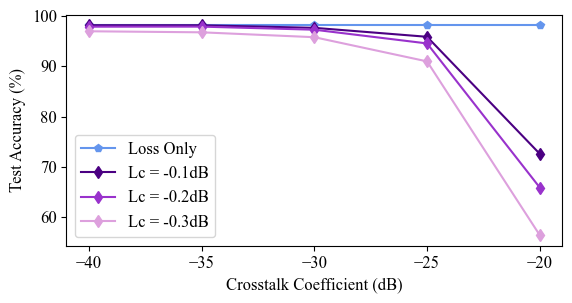

In [30]:
# Annotate Setup
plt.figure(figsize=(6.4, 3))
plt.plot(x, y_lossonly, '-p', color='cornflowerblue')
plt.plot(x, y[0], '-d', color='indigo')
plt.plot(x, y[1], '-d', color='darkorchid')
plt.plot(x, y[2], '-d', color='plum')
plt.xticks(x)
plt.xlabel('Crosstalk Coefficient (dB)')
plt.ylabel('Test Accuracy (%)')
plt.legend(['Loss Only','Lc = -0.1dB', 'Lc = -0.2dB', 'Lc = -0.3dB'])
plt.show()

# Full DNN-Architecture Evaluation

In [92]:
class PNN:
    def __init__(self, matrix, Lp_dB=0, Lc_dB=0, K1_dB=-10000, K2_dB=-10000):
        [self.u, self.s, self.v] = np.linalg.svd(matrix, full_matrices=True)
        [self.p_u, self.t_u, self.a_u] = decompose_clements(self.u.conj().T, block='mzi')
        [self.p_v, self.t_v, self.a_v] = decompose_clements(self.v.conj().T, block='mzi')
        self.Lp_dB, self.Lc_dB = Lp_dB, Lc_dB
        self.K1_dB, self.K2_dB = K1_dB, K2_dB
        
    def __call__(self, inputs, return_crosstalk=False):
        pnn_inputs = inputs.squeeze()[:,np.newaxis].astype(np.complex128)
        [E_sig, P_xtalk] = reconstruct_clements_pnn(self.p_u, self.t_u, self.a_u, 
                                 pnn_inputs,
                                 np.zeros_like(pnn_inputs, dtype=np.complex128),
                                 block='mzi',
                                 Lp_dB=self.Lp_dB, Lc_dB=self.Lc_dB, K1_dB=self.K1_dB, K2_dB=self.K2_dB)
        if not return_crosstalk:
            E_sig = photo_detector(E_sig, P_xtalk)
        
        E_sig = diagonal_attenuator(E_sig, self.s, num_output=self.v.shape[0])
        P_xtalk = diagonal_attenuator(P_xtalk, self.s, num_output=self.v.shape[0])
        
        [E_sig, P_xtalk] = reconstruct_clements_pnn(self.p_v, self.t_v, self.a_v,
                                 E_sig,
                                 P_xtalk,
                                 block='mzi',
                                 Lp_dB=self.Lp_dB, Lc_dB=self.Lc_dB, K1_dB=self.K1_dB, K2_dB=self.K2_dB)
        if not return_crosstalk:
            E_sig = photo_detector(E_sig, P_xtalk)
        
        if return_crosstalk:
            return E_sig, P_xtalk
        else:
            return E_sig

## Measurement of Post-Rectification Factor

In [177]:
Lp_dB = -0.05
Lc_dB = -0.1
K1_dB = -30
K2_dB = -30

pnn_test = PNN(np.eye(120), Lp_dB=Lp_dB, Lc_dB=Lc_dB, K1_dB=K1_dB, K2_dB=K2_dB)
[E_sig, P_xtalk] = pnn_test(pnn_inputs, return_crosstalk=True)

avg_intensity = np.mean(np.abs(E_sig) ** 2 + P_xtalk)
eta_factor = 1 / avg_intensity

print(avg_intensity.real, np.mean(np.abs(E_sig) ** 2).real, np.mean(P_xtalk).real)
print(f'Post Rectification Factor: eta = {np.real(eta_factor)} = {10 ** (np.real(eta_factor)/10)} dB')

0.08373056595427864 0.06623061625973564 0.017499949694542983
Post Rectification Factor: eta = 11.943069876609378 = 15.642529679424353 dB


**Note:** Mapping algorithms for large-scale DNNs are moved to another project, of which paper is expected to publish in ASPLOS.